In [1]:
# standard imports
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
#import pygmt
from pyproj import Proj, Geod
from osgeo import gdal

import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt


# user-defined imports
import tdcalc

# reload modules when changed
%reload_ext autoreload
%autoreload 2

In [3]:
projfolder = '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/'

P = Proj('epsg:32610')
G = Geod(ellps='WGS84')

## Fault Geometry

In [9]:
from pyproj import Proj, Geod
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

P = Proj('epsg:32610')
G = Geod(ellps='WGS84')

In [10]:
nesurf_pts = pd.read_csv('/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/GIS/FinalFaultGeomFiles/MRMRTraceNE.csv')
nesurf_pts['lon'], nesurf_pts['lat'] = P(nesurf_pts.X.values,nesurf_pts.Y.values,inverse=True)
nesurf_pts['Z'] = np.zeros(len(nesurf_pts))

In [11]:
swsurf_pts = pd.read_csv('/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/GIS/FinalFaultGeomFiles/MRMRTraceSW.csv')
swsurf_pts['lon'], swsurf_pts['lat'] = P(swsurf_pts.X.values,swsurf_pts.Y.values,inverse=True)
swsurf_pts['Z'] = np.zeros(len(swsurf_pts))

In [12]:
depth_pts = pd.read_csv('/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/GIS/FinalFaultGeomFiles/AlongiFaultPointsMRMR.csv')
depth_pts['lon'], depth_pts['lat'] = P(depth_pts.x.values,depth_pts.y.values,inverse=True)
depth_pts = depth_pts[((depth_pts.z >= -5500)&
                       (depth_pts.x >= nesurf_pts.X.min())&
                       (depth_pts.x <= swsurf_pts.X.max())& 
                       (depth_pts.y <= nesurf_pts.Y.max())&
                       (depth_pts.y >= swsurf_pts.Y.min()))]
depth_pts.columns = ['X', 'Y', 'Z', 'lon', 'lat']


[694497.92489424] [701660.9247553]
[694853.23982432] [701464.41344639]
[694215.82373414] [697867.07373414]
[695143.62928969] [701693.97187662]


/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/

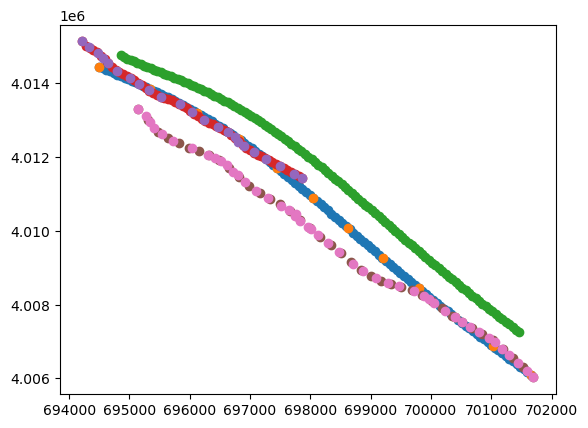

In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

filtered = depth_pts[depth_pts['Z'] >= -3200]
X = filtered['X'].values.reshape(-1, 1)
y = filtered['Y'].values
# Set up Gaussian Process
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1e4, length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(X, y)
# Prediction grid
xs_shallow_depth = np.linspace(X.min(), X.max(), 120).reshape(-1, 1)
print(min(xs_shallow_depth),max(xs_shallow_depth))
shallow_depth = gp.predict(xs_shallow_depth)

plt.scatter(xs_shallow_depth,shallow_depth)
plt.scatter(X,y)

filtered = depth_pts[depth_pts['Z'] <= -5000]
X = filtered['X'].values.reshape(-1, 1)
y = filtered['Y'].values
# Set up Gaussian Process
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1e4, length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(X, y)
# Prediction grid
xs_deep_depth = np.linspace(X.min(), X.max(), 120).reshape(-1, 1)
print(min(xs_deep_depth),max(xs_deep_depth))
deep_depth = gp.predict(xs_deep_depth)

plt.scatter(xs_deep_depth,deep_depth)

filtered = nesurf_pts
X = filtered['X'].values.reshape(-1, 1)
y = filtered['Y'].values
# Set up Gaussian Process
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1e3, length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(X, y)
# Prediction grid
xs_ne_surf = np.linspace(X.min(), X.max(), 60).reshape(-1, 1)
print(min(xs_ne_surf),max(xs_ne_surf))
ne_surf = gp.predict(xs_ne_surf)

plt.scatter(xs_ne_surf,ne_surf)
plt.scatter(X,y)

filtered = swsurf_pts
X = filtered['X'].values.reshape(-1, 1)
y = filtered['Y'].values
# Set up Gaussian Process
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1e3, length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(X, y)
# Prediction grid
xs_sw_surf = np.linspace(X.min(), X.max(), 40).reshape(-1, 1)
print(min(xs_sw_surf),max(xs_sw_surf))
sw_surf = gp.predict(xs_sw_surf)

plt.scatter(xs_sw_surf,sw_surf)
plt.scatter(X,y)

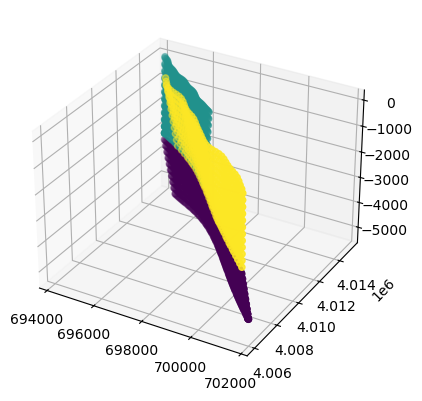

In [30]:
# Extend shallow depth to deep depth
  
nfault_pts = len(np.arange(0,3000,250)) * len(sw_surf) + len(np.arange(0,3000,250)) * len(ne_surf) + len(np.arange(3000,5500,250)) * len(shallow_depth)

X, Y, Z = np.empty(nfault_pts), np.empty(nfault_pts), np.empty(nfault_pts)
ids = np.empty(nfault_pts)
# Build a KDTree for the points in list_B
tree = KDTree(np.column_stack([xs_deep_depth,deep_depth]))
distances, indices = tree.query(np.column_stack([xs_shallow_depth,shallow_depth]))

for i,depth in enumerate(np.arange(3000,5500,250)):
    # Find closest point
    fraction = (depth - 3000) / (-3000 + 5500)
    x = xs_shallow_depth + fraction * (xs_deep_depth[indices]-xs_shallow_depth)
    y = shallow_depth + fraction * (deep_depth[indices]-shallow_depth)

    X[i*len(x):i*len(x)+len(x)] = x.flatten()
    Y[i*len(x):i*len(x)+len(x)] = y.flatten()
    Z[i*len(x):i*len(x)+len(x)] = np.ones(len(x))*-1*depth
    ids[i*len(x):i*len(x)+len(x)] = np.ones(len(x))*0

i_prev = i*len(x)+len(x)

# Build a KDTree for the points in list_B
tree = KDTree(np.column_stack([xs_shallow_depth,shallow_depth]))
distances, indices = tree.query(np.column_stack([xs_ne_surf,ne_surf]))

for i,depth in enumerate(np.arange(0,3000,250)):
    # Find closest point
    fraction = (depth + 0) / (-0 + 3000)
    x = xs_ne_surf + fraction * (xs_shallow_depth[indices]-xs_ne_surf)
    y = ne_surf + fraction * (shallow_depth[indices]-ne_surf)

    X[i_prev+i*len(x):i_prev+i*len(x)+len(x)] = x.flatten()
    Y[i_prev+i*len(x):i_prev+i*len(x)+len(x)] = y.flatten()
    Z[i_prev+i*len(x):i_prev+i*len(x)+len(x)] = np.ones(len(x))*-1*depth
    ids[i_prev+i*len(x):i_prev+i*len(x)+len(x)] = np.ones(len(x))*1

i_prev = i_prev+i*len(x)+len(x)

# Build a KDTree for the points in list_B
tree = KDTree(np.column_stack([xs_shallow_depth,shallow_depth]))
distances, indices = tree.query(np.column_stack([xs_sw_surf,sw_surf]))

for i,depth in enumerate(np.arange(0,3000,250)):
    # Find closest point
    fraction = (depth + 0) / (-0 + 3000)
    x = xs_sw_surf + fraction * (xs_shallow_depth[indices]-xs_sw_surf)
    y = sw_surf + fraction * (shallow_depth[indices]-sw_surf)

    X[i_prev+i*len(x):i_prev+i*len(x)+len(x)] = x.flatten()
    Y[i_prev+i*len(x):i_prev+i*len(x)+len(x)] = y.flatten()
    Z[i_prev+i*len(x):i_prev+i*len(x)+len(x)] = np.ones(len(x))*-1*depth
    ids[i_prev+i*len(x):i_prev+i*len(x)+len(x)] = np.ones(len(x))*2


fltpts = pd.DataFrame({'X':X,'Y':Y,'Z':Z,'ID':ids})
fltpts.to_csv('/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/GIS/FinalFaultGeomFiles/FaultPointsMRMR.csv',index=False)


%matplotlib inline
ax = plt.figure().add_subplot(projection='3d',)
ax.scatter(X,Y,Z,c=ids)

In [31]:
triangles = []
centroids = []

pts1 = fltpts[fltpts.ID == 1][['X','Y','Z']].values
pts2 = fltpts[fltpts.ID == 2][['X','Y','Z']].values
pts3 = fltpts[fltpts.ID == 0][['X','Y','Z']].values

for pts in [pts1,pts2]:
    # Perform Delaunay triangulation, using X-D frame
    pts = np.concat([pts,pts3])
    tri = Delaunay(pts[:,(0,2)])

    # Create the triangulated surface
    for indices in tri.simplices:
        triangles.append(pts[indices])

triangles = np.array(triangles)
print("Original number of triangles:", len(triangles))

# Remove duplicate triangles
tmp = triangles.copy().reshape(-1, 9)
tmp.sort(axis=1)
_ , id = np.unique(tmp,axis=0,return_index=True)
triangles = triangles.reshape(-1, 9)[id].reshape(-1,3,3)

print("Number of unique triangles:", len(triangles))

# Function to remove triangles with long edges
def remove_long_edge_triangles(triangles, max_edge_length):
    filtered_triangles = []
    for triangle in triangles:
        # Calculate the squared lengths of the three edges
        edge_lengths_sq = [
            np.sum((triangle[0] - triangle[1])**2),
            np.sum((triangle[1] - triangle[2])**2),
            np.sum((triangle[2] - triangle[0])**2),
        ]
        # Check if all edges are within the threshold
        if all(length_sq <= max_edge_length**2 for length_sq in edge_lengths_sq):
            filtered_triangles.append(triangle)
    return np.array(filtered_triangles)

# Remove triangles with edges over the threshold
max_edge_length = 2000.0  # Set your threshold
triangles = remove_long_edge_triangles(triangles, max_edge_length)
print("Number of triangles after filtering:", len(triangles))

# Calculate centroids
centroids = []
for triangle in triangles:
    centroids.append(np.array([np.mean(triangle[:,0]),
                     np.mean(triangle[:,1]),
                     np.mean(triangle[:,2])]))
centroids = np.array(centroids)
print("Centroids:", centroids)

# Save
np.save('/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/GIS/FinalFaultGeomFiles/tris_xyz.npy',triangles)
np.save('/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/GIS/FinalFaultGeomFiles/tricentroids_xyz.npy',centroids)

Original number of triangles: 6817
Number of unique triangles: 4675
Number of triangles after filtering: 4610
Centroids: [[ 6.94811884e+05  4.01471320e+06 -5.16666667e+03]
 [ 6.94851391e+05  4.01468299e+06 -5.16666667e+03]
 [ 6.94907566e+05  4.01464055e+06 -5.16666667e+03]
 ...
 [ 7.01300452e+05  4.00662234e+06 -8.33333333e+01]
 [ 7.01468760e+05  4.00637854e+06 -8.33333333e+01]
 [ 7.01637068e+05  4.00611573e+06 -8.33333333e+01]]


In [32]:
import vtk

colors = np.zeros(len(triangles))  # Scalar values for each triangle

# Create a VTK Points object to store vertices
points = vtk.vtkPoints()
vertices = triangles.reshape(-1, 3)  # Flatten triangle vertices to unique points

# Map unique vertices to indices
unique_vertices, inverse_indices = np.unique(vertices, axis=0, return_inverse=True)

# Add unique vertices to VTK Points
for vertex in unique_vertices:
    points.InsertNextPoint(vertex)

# Create a VTK CellArray to store the triangles
cells = vtk.vtkCellArray()

# Add each triangle to the CellArray
for tri_indices in inverse_indices.reshape(-1, 3):
    triangle = vtk.vtkTriangle()
    for i, idx in enumerate(tri_indices):
        triangle.GetPointIds().SetId(i, idx)
    cells.InsertNextCell(triangle)

# Create a VTK PolyData object
polydata = vtk.vtkPolyData()
polydata.SetPoints(points)
polydata.SetPolys(cells)

# Add scalar values (colors) as cell data
color_array = vtk.vtkFloatArray()
color_array.SetName("Colors")  # Name of the scalar field
color_array.SetNumberOfComponents(1)

for color in colors:
    color_array.InsertNextValue(color)

polydata.GetCellData().SetScalars(color_array)

# Write to a VTK file
writer = vtk.vtkXMLPolyDataWriter()
writer.SetFileName('/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/GIS/FinalFaultGeomFiles/triangular_mesh.vtp')
writer.SetInputData(polydata)
writer.Write()

1

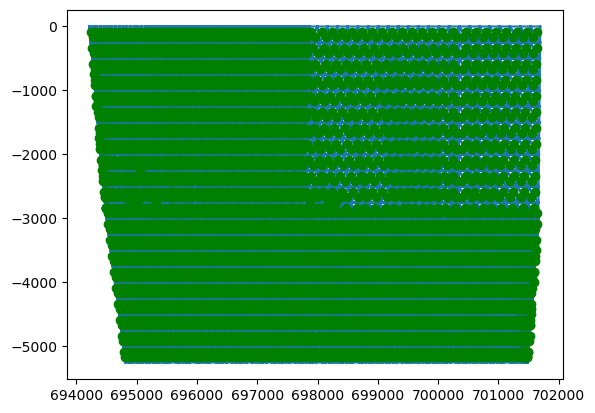

In [33]:
points = triangles.reshape(-1, 3)

# Create an array of triangle indices
num_triangles = triangles.shape[0]
indices = np.arange(len(points)).reshape(num_triangles, 3)

# Plot the triangulation using triplot
plt.triplot(points[:,0], points[:,2], indices)#, color=edgecolor, alpha=alpha)
plt.scatter(centroids[:,0], centroids[:,2],c='green')

## Make Obs Grid

In [34]:
import rioxarray

In [35]:
# Bounding polygon +-5000 m from fault max SW and minSE points
coords = []
px,py = P(max(centroids[:,0]),centroids[:,1][np.where(centroids[:,0] == max(centroids[:,0]))][0],inverse=True)
coords.append(list(G.fwd(px,py,-135,-5000)[0:-1]))
px,py = P(max(centroids[:,0]),centroids[:,1][np.where(centroids[:,0] == max(centroids[:,0]))][0],inverse=True)
coords.append(list(G.fwd(px,py,-135,5000)[0:-1]))
px,py = P(min(centroids[:,0]),centroids[:,1][np.where(centroids[:,0] == min(centroids[:,0]))][0],inverse=True)
coords.append(list(G.fwd(px,py,-135,5000)[0:-1]))
px,py = P(min(centroids[:,0]),centroids[:,1][np.where(centroids[:,0] == min(centroids[:,0]))][0],inverse=True)
coords.append(list(G.fwd(px,py,-135,-5000)[0:-1]))
coords.append(coords[0])
coords = np.array(coords)
coords = np.column_stack([P(coords[:,0],coords[:,1])[0],P(coords[:,0],coords[:,1])[1]])
#polygon = Polygon(coords)
geometries = [
    {
        'type': 'Polygon',
        'coordinates': [coords.tolist()]
    }
]

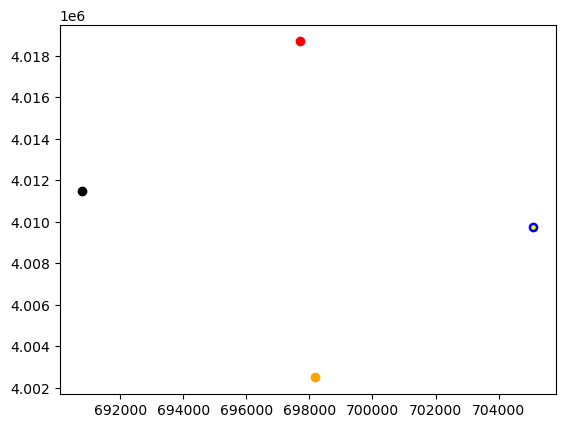

In [36]:
plt.scatter(coords[0,0],coords[0,1],color='b')
plt.scatter(coords[1,0],coords[1,1],color='orange')
plt.scatter(coords[2,0],coords[2,1],color='black')
plt.scatter(coords[3,0],coords[3,1],color='red')
plt.scatter(coords[4,0],coords[4,1],color='yellow',s=5)

In [39]:
lidparf = '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/DisplacementRasters/MR_lidar_demeaned.tif'
uavparf = '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/DisplacementRasters/MR_uavlosv_demeaned.tif'

lidpar = rioxarray.open_rasterio(lidparf,masked=True)
lidpar = lidpar.rio.reproject('EPSG:32610')
lidpar.data = lidpar.data
lidpar = lidpar.rio.clip(geometries)

uavpar = rioxarray.open_rasterio(uavparf)
uavpar = uavpar.rio.reproject('EPSG:32610')
uavpar = uavpar.rio.clip(geometries)


In [59]:
import numpy as np
import pandas as pd
import rioxarray
from scipy.spatial import cKDTree

# Helper function to check if a point is inside a polygon using ray-casting
def is_point_in_polygon(x, y, polygon):
    """
    Determine if a point is inside a polygon using the ray-casting algorithm.
    Args:
        x (float): X-coordinate of the point.
        y (float): Y-coordinate of the point.
        polygon (list): List of [x, y] vertices defining the polygon.
    Returns:
        bool: True if the point is inside the polygon, False otherwise.
    """
    num_vertices = len(polygon)
    inside = False
    for i in range(num_vertices):
        x1, y1 = polygon[i]
        x2, y2 = polygon[(i + 1) % num_vertices]
        if ((y1 > y) != (y2 > y)) and (x < (x2 - x1) * (y - y1) / (y2 - y1) + x1):
            inside = not inside
    return inside

# Parameters
fault_points = fltpts[fltpts.Z>-0.4][['X','Y']]
max_points = 10000  # Maximum number of points in the subsampled dataset
sigma = 200
spacing = 500  # Approximate spacing for random points in meters
num_random_points = 1000  # Number of random points to generate


# Step 2: Extract grid points and values
x_coords, y_coords = np.meshgrid(lidpar.x, lidpar.y)
x_coords = x_coords.ravel()
y_coords = y_coords.ravel()
values = lidpar.data[0].ravel()  # Assuming single-band raster

# Remove NaN points
valid_mask = ~np.isnan(values)
x_coords = x_coords[valid_mask]
y_coords = y_coords[valid_mask]
values = values[valid_mask]

# Step 3: Compute distances to fault points
tree = cKDTree(fault_points)  # Efficient distance calculation
distances, _ = tree.query(np.column_stack((x_coords, y_coords)))

# Step 4: Compute Gaussian sampling probabilities
probabilities = np.exp(-distances**2 / (2 * sigma**2))
probabilities /= probabilities.max()  # Normalize probabilities to [0, 1]

# Step 5: Apply subsampling
random_values = np.random.rand(len(probabilities))
subsample_mask = random_values < probabilities
subsampled_coords = np.column_stack((x_coords[subsample_mask], y_coords[subsample_mask]))
subsampled_values = values[subsample_mask]
subsampled_distances = distances[subsample_mask]

# Limit to max points
if len(subsampled_coords) > max_points:
    selected_indices = np.random.choice(len(subsampled_coords), max_points, replace=False)
    subsampled_coords = subsampled_coords[selected_indices]
    subsampled_values = subsampled_values[selected_indices]
    subsampled_distances = subsampled_distances[selected_indices]

# Step 6: Generate random points within the polygon
random_points = []
xmin, ymin = np.min(coords, axis=0)
xmax, ymax = np.max(coords, axis=0)

while len(random_points) < num_random_points:
    # Generate random coordinates within the bounding box
    x_rand = np.random.uniform(xmin, xmax)
    y_rand = np.random.uniform(ymin, ymax)
    # Check if the point is inside the polygon
    if is_point_in_polygon(x_rand, y_rand, coords):
        random_points.append([x_rand, y_rand])

random_coords = np.array(random_points)

# Step 7: Combine subsampled grid and random points
combined_coords = np.vstack((subsampled_coords, random_coords))
combined_values = np.concatenate((subsampled_values, np.full(len(random_coords), np.nan)))
combined_distances = np.concatenate((subsampled_distances, np.full(len(random_coords), np.nan)))

# Step 8: Create and save the output
output_array = np.column_stack((combined_coords[:, 0], combined_coords[:, 1], combined_values, combined_distances))
output_df = pd.DataFrame(output_array, columns=["X", "Y", "Value", "Distance_to_Closest_Fault"])
output_df['Z'] = np.zeros(len(output_df))


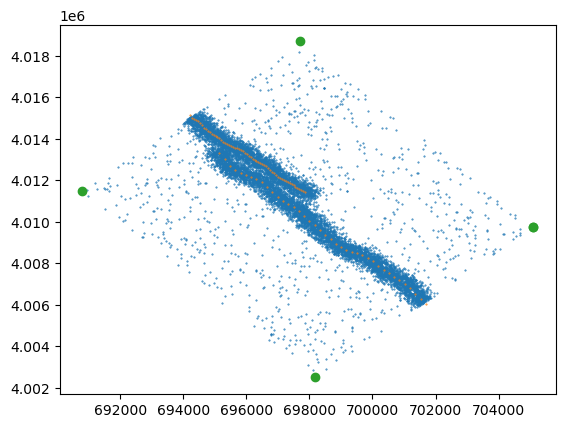

In [62]:
plt.scatter(output_df.X,output_df.Y,s=0.2)
plt.scatter(fault_points.X,fault_points.Y,s=0.2)
plt.scatter(coords[:,0],coords[:,1])

In [66]:
# Save positions

np.save('/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/GIS/FinalFaultGeomFiles/obs_xyz.npy',output_df[['X','Y','Z']].values)


## Create Green's functions

In [1]:
# standard imports
import numpy as np
import pandas as pd

# user-defined imports
import tdcalc

# reload modules when changed
%reload_ext autoreload
%autoreload 2

projfolder = '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/'


In [101]:
# generate half-space displacements and strains 
obs = np.load(projfolder+'GIS/FinalFaultGeomFiles/obs_xyz.npy')
triangles = np.load(projfolder+'GIS/FinalFaultGeomFiles/tris_xyz.npy')
di = np.ones(len(triangles))

# initiate
i=0
tri = triangles[i]
ss = [di[i]]
ds = np.zeros(len(ss))
op = np.zeros(len(ss))
dx = np.empty([len(obs),len(di)])
dy = np.empty([len(obs),len(di)])
dz = np.empty([len(obs),len(di)])
slip=[ss,ds,op]
nu=0.25

displ = tdcalc.TDdispHS(obs,tri,slip,nu)
dx[:,i] = displ[:,0]
dy[:,i] = displ[:,1]
dz[:,i] = displ[:,2]

for i in range(1,len(triangles)):
    print(i,i/len(triangles))
    tri = triangles[i]
    ss = [di[i]]
    ds = np.zeros(len(ss))
    op = np.zeros(len(ss))
    slip=[ss,ds,op]
    displ = tdcalc.TDdispHS(obs,tri,slip,nu)
    dx[:,i] = displ[:,0]
    dy[:,i] = displ[:,1]
    dz[:,i] = displ[:,2]

print('displ',displ, np.shape(displ))
# Save displacements
np.save(projfolder+'SlipInversion/dx.npy',dx)
np.save(projfolder+'SlipInversion/dy.npy',dy)
np.save(projfolder+'SlipInversion/dz.npy',dz)



1 0.00021691973969631235
2 0.0004338394793926247
3 0.0006507592190889371
4 0.0008676789587852494
5 0.0010845986984815619
6 0.0013015184381778742
7 0.0015184381778741865
8 0.0017353579175704988
9 0.0019522776572668114
10 0.0021691973969631237
11 0.002386117136659436
12 0.0026030368763557484
13 0.0028199566160520607
14 0.003036876355748373
15 0.0032537960954446853
16 0.0034707158351409977
17 0.00368763557483731
18 0.0039045553145336228
19 0.004121475054229935
20 0.004338394793926247
21 0.00455531453362256
22 0.004772234273318872
23 0.004989154013015184
24 0.005206073752711497
25 0.005422993492407809
26 0.005639913232104121
27 0.005856832971800434
28 0.006073752711496746
29 0.006290672451193058
30 0.006507592190889371
31 0.006724511930585683
32 0.006941431670281995
33 0.007158351409978308
34 0.00737527114967462
35 0.007592190889370932
36 0.0078091106290672455
37 0.008026030368763558
38 0.00824295010845987
39 0.008459869848156183
40 0.008676789587852495
41 0.008893709327548807
42 0.0091106

/Users/chanagan/Documents/GitHub/tdcalc/tdcalc.py:209: RuntimeWarning: invalid value encountered in arccos
  A = np.arccos(e12.T.dot(e13))
/Users/chanagan/Documents/GitHub/tdcalc/tdcalc.py:211: RuntimeWarning: invalid value encountered in arccos
  C = np.arccos(e23.T.dot(e13))


487 0.10563991323210412
488 0.10585683297180043
489 0.10607375271149674
490 0.10629067245119306
491 0.10650759219088937
492 0.10672451193058569
493 0.106941431670282
494 0.10715835140997831
495 0.10737527114967461
496 0.10759219088937093
497 0.10780911062906724
498 0.10802603036876356
499 0.10824295010845987
500 0.10845986984815618
501 0.1086767895878525
502 0.10889370932754881
503 0.10911062906724511
504 0.10932754880694143
505 0.10954446854663774
506 0.10976138828633406
507 0.10997830802603037
508 0.11019522776572668
509 0.110412147505423
510 0.11062906724511931
511 0.11084598698481561
512 0.11106290672451193
513 0.11127982646420824
514 0.11149674620390455
515 0.11171366594360087
516 0.11193058568329718
517 0.1121475054229935
518 0.11236442516268981
519 0.11258134490238612
520 0.11279826464208242
521 0.11301518438177874
522 0.11323210412147505
523 0.11344902386117137
524 0.11366594360086768
525 0.113882863340564
526 0.11409978308026031
527 0.11431670281995662
528 0.11453362255965292


/Users/chanagan/Documents/GitHub/tdcalc/tdcalc.py:210: RuntimeWarning: invalid value encountered in arccos
  B = np.arccos(-e12.T.dot(e23))


2445 0.5303687635574837
2446 0.53058568329718
2447 0.5308026030368763
2448 0.5310195227765727
2449 0.531236442516269
2450 0.5314533622559653
2451 0.5316702819956616
2452 0.531887201735358
2453 0.5321041214750543
2454 0.5323210412147505
2455 0.5325379609544468
2456 0.5327548806941431
2457 0.5329718004338395
2458 0.5331887201735358
2459 0.5334056399132321
2460 0.5336225596529284
2461 0.5338394793926248
2462 0.5340563991323211
2463 0.5342733188720173
2464 0.5344902386117136
2465 0.53470715835141
2466 0.5349240780911063
2467 0.5351409978308026
2468 0.5353579175704989
2469 0.5355748373101952
2470 0.5357917570498916
2471 0.5360086767895879
2472 0.5362255965292841
2473 0.5364425162689804
2474 0.5366594360086768
2475 0.5368763557483731
2476 0.5370932754880694
2477 0.5373101952277657
2478 0.5375271149674621
2479 0.5377440347071584
2480 0.5379609544468547
2481 0.5381778741865509
2482 0.5383947939262473
2483 0.5386117136659436
2484 0.5388286334056399
2485 0.5390455531453362
2486 0.539262472885032

## Bring in Displacements for inversion

In [2]:
from pyproj import Proj, Geod
import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
%load_ext autoreload
%autoreload 2

In [3]:
projfolder = '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/'

P = Proj('epsg:32610')
G = Geod(ellps='WGS84')

In [ ]:
obsdf = pd.read_csv(projfolder+'SlipInversion/MergedObsDispAggregate.csv')
obsdf.columns = ['lon','lat','ParVel']
obsdf['X'], obsdf['Y'] = P(obsdf.lon,obsdf.lat)

dx = np.load(projfolder+'SlipInversion/dx.npy')
dx = dx.astype(np.float32)
dy = np.load(projfolder+'SlipInversion/dy.npy')
dy = dy.astype(np.float32)
#dz = np.load(projfolder+'dz.npy')
#dz = dz.astype(np.float32)

# Rotation from en (xy) to fault parallel and perp, must convert azimuth
azimuth = -45
theta = (90-azimuth)*np.pi/180
par = dy*np.sin(theta)+dx*np.cos(theta)
par[np.isnan(par)] = 0

# Save positions
obs_pts = np.load(projfolder+'GIS/FinalFaultGeomFiles/obs_xyz.npy')
triangles = np.load(projfolder+'GIS/FinalFaultGeomFiles/tris_xyz.npy')
centroids = np.load(projfolder+'GIS/FinalFaultGeomFiles/tricentroids_xyz.npy')

#del dx, dy, triangles

import numpy as np

# Example data
larger_positions = obsdf[['X', 'Y']].values
subset_positions = obs_pts[:,(0,1)]
#
## Build a KDTree for the subset positions
tree = cKDTree(subset_positions)
#
## Query the closest point in the subset for each point in the larger set
distances, indices = tree.query(larger_positions)
#
## Print results
#print("Indices of closest points in subset:", indices)
print("Distances to closest points:", distances)
#
#del larger_positions, subset_positions, tree, distances

from scipy.sparse import csr_matrix
# Build matrices for inversion
G = par[indices,:] # Reorder G to match the observed slip vector,
#colid = np.where(centroids[:,-1]>-5000)[0]
#G = G[:,colid] # get rid of fault points below 5 km, make sparse matrix to save mempry
#del par, indices, obs_pts
# Sparse matrices, observations
G[np.absolute(G)<0.000001] = 0 # zeros for the sparse matrix operation, anything < 1 mm discarded as insignificatnt
G = csr_matrix(G)
d = obsdf['ParVel'].values


faultdf = pd.DataFrame({'e':centroids[:,0],
                        'n':centroids[:,1],
                        'z':centroids[:,2]})

from scipy.spatial import cKDTree
tree = cKDTree(obsdf[['X','Y']])
dist, _  = tree.query(obsdf[['X','Y']],k=2)
dist = dist[:,1]



Distances to closest points: [1.16415322e-09 5.82076609e-10 9.38570330e-10 ... 1.67896565e-09
 9.38570330e-10 5.20625146e-10]


3.6468258978251336


(array([  1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   1.,   2.,
          2.,   0.,   2.,   3.,   7.,  11.,  33.,  31.,  45.,  91., 129.,
        171., 197., 229., 232., 198., 177., 171., 216., 204., 212., 205.,
        190., 173., 114., 139., 115., 100., 103., 104., 104., 110., 125.,
        107., 102.,  96., 101.,  90., 110.,  90., 135.,  84., 113.,  91.,
         75.,  89.,  93., 106., 113., 106., 111., 117., 122., 122., 133.,
        122., 130., 131., 167., 165., 188., 218., 251., 275., 272., 354.,
        363., 326., 346., 276., 265., 264., 196., 135.,  87.,  57.,  44.,
         29.,  22.,  12.,   8.,   7.,   2.,   2.,   0.,   1.,   0.,   0.,
          3.]),
 array([-2.27961452, -2.23773782, -2.19586112, -2.15398441, -2.11210771,
        -2.07023101, -2.02835431, -1.98647761, -1.94460091, -1.90272421,
        -1.8608475 , -1.8189708 , -1.7770941 , -1.7352174 , -1.6933407 ,
        -1.651464  , -1.6095873 , -1.56771059, -1.52583389, -1.48395719,
        -1.44208049, -1.40

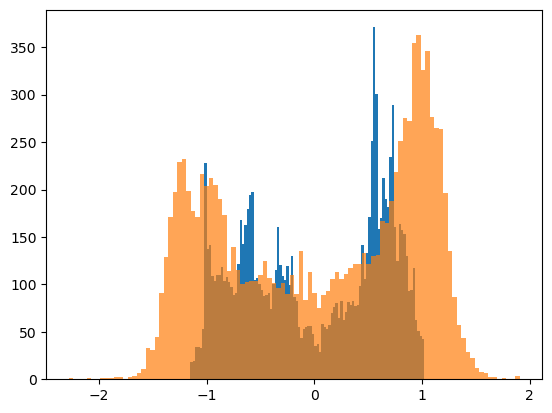

In [5]:
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import Ridge

def build_kernel_sparse(G, faultdf, length_scale, chunk_size=1000):
    """
    Builds the sparse kernel matrix and kernelized Green's functions matrix.

    Parameters:
        G (csr_matrix): Sparse Green's functions matrix.
        faultdf (pd.DataFrame): DataFrame with fault points (columns 'n', 'e', 'z').
        length_scale (float): Length scale for the Gaussian kernel.
        chunk_size (int): Number of rows to process at a time to avoid memory issues.

    Returns:
        Kk (csr_matrix): Sparse kernel matrix.
        Gk (csr_matrix): Sparse kernelized Green's functions matrix.
    """
    kernel = RBF(length_scale, length_scale_bounds='fixed')
    locs = faultdf[['n', 'e', 'z']].values

    # Initialize sparse kernel matrix using lil_matrix for efficient updates
    num_points = locs.shape[0]
    Kk = lil_matrix((num_points, num_points), dtype=np.float64)

    # Compute kernel matrix in chunks
    for i in range(0, num_points, chunk_size):
        chunk_locs = locs[i:i + chunk_size]
        chunk_kernel = kernel.__call__(chunk_locs, locs) / (np.sqrt(2 * np.pi) * length_scale)
        Kk[i:i + chunk_size, :] = chunk_kernel  # Efficient assignment in lil format

    # Convert to csr_matrix after all updates
    Kk = Kk.tocsr()

    # Kernelize Green's functions matrix
    Gk = G @ Kk
    return Kk, Gk

def ridge_soln(Gk, d_obs, weights, alpha, kernel):
    """
    Solves the ridge regression problem with sparse inputs.

    Parameters:
        Gk (csr_matrix): Kernelized Green's functions matrix.
        d_obs (np.ndarray): Observed data.
        weights (np.ndarray): Data weights (1/sigma^2).
        alpha (float): Regularization parameter.
        kernel (csr_matrix): Sparse kernel matrix.

    Returns:
        np.ndarray: Model parameters.
    """
    enet = Ridge(fit_intercept=False,positive=True,alpha=alpha,solver='lbfgs').fit(Gk,d_obs,sample_weight=weights)
    m = kernel @ enet.coef_
    return m

# Example
length_scale = 250 # in m if the fault e, n, z are in m
Kk, Gk = build_kernel_sparse(G,faultdf,length_scale)
a = 0.01
# FLIP SIGN ON D! Ooops
weights = dist
m = ridge_soln(Gk,-1*d,weights,alpha=a,kernel=Kk)
d_mod = G@m
print(max(m))

plt.hist(d_mod,bins=100)
plt.hist(-1*d,bins=100,alpha=0.7)


12.369727445813504


(array([  1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   1.,   2.,
          2.,   0.,   2.,   3.,   7.,  11.,  33.,  31.,  45.,  91., 129.,
        171., 197., 229., 232., 198., 177., 171., 216., 204., 212., 205.,
        190., 173., 114., 139., 115., 100., 103., 104., 104., 110., 125.,
        107., 102.,  96., 101.,  90., 110.,  90., 135.,  84., 113.,  91.,
         75.,  89.,  93., 106., 113., 106., 111., 117., 122., 122., 133.,
        122., 130., 131., 167., 165., 188., 218., 251., 275., 272., 354.,
        363., 326., 346., 276., 265., 264., 196., 135.,  87.,  57.,  44.,
         29.,  22.,  12.,   8.,   7.,   2.,   2.,   0.,   1.,   0.,   0.,
          3.]),
 array([-2.27961452, -2.23773782, -2.19586112, -2.15398441, -2.11210771,
        -2.07023101, -2.02835431, -1.98647761, -1.94460091, -1.90272421,
        -1.8608475 , -1.8189708 , -1.7770941 , -1.7352174 , -1.6933407 ,
        -1.651464  , -1.6095873 , -1.56771059, -1.52583389, -1.48395719,
        -1.44208049, -1.40

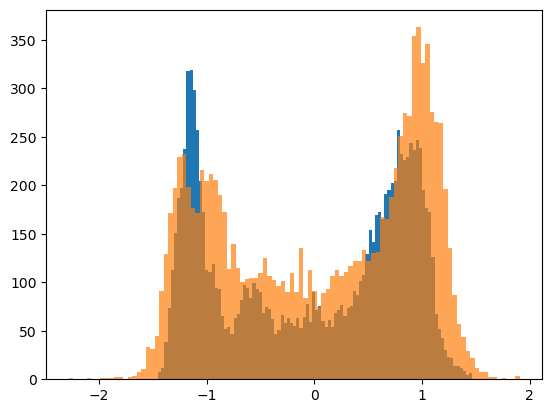

In [54]:
a = 0.01
# FLIP SIGN ON D! Ooops
weights = 0.1*dist**2
m = ridge_soln(Gk,-1*d,weights,alpha=a,kernel=Kk)
d_mod = G@m
print(max(m))

faultdf['strike_slip'] = m

plt.hist(d_mod,bins=100)
plt.hist(-1*d,bins=100,alpha=0.7)



(array([ 475., 1102., 1360.,  536.,  251.,  197.,  183.,  244.,  200.,
          62.]),
 array([ 0.02195828,  1.2567352 ,  2.49151211,  3.72628903,  4.96106595,
         6.19584286,  7.43061978,  8.6653967 ,  9.90017361, 11.13495053,
        12.36972745]),
 <BarContainer object of 10 artists>)

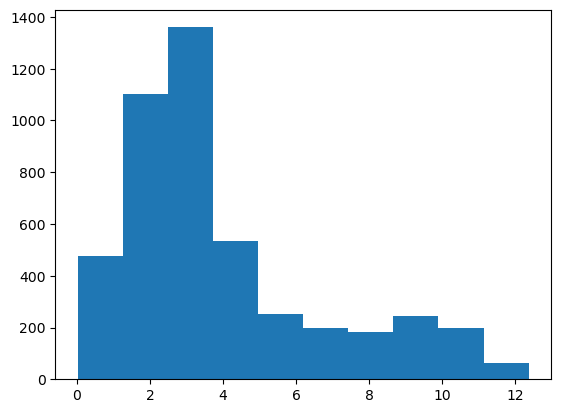

In [55]:
plt.hist(m)

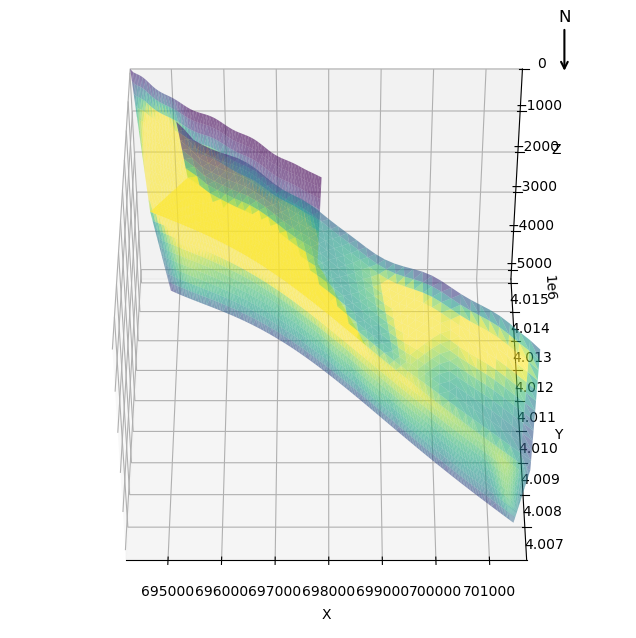

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# Save positions
triangles = np.load(projfolder+'GIS/FinalFaultGeomFiles/tris_xyz.npy')

# Extract vertices for plotting
x = triangles[:, :, 0].flatten()
y = triangles[:, :, 1].flatten()
z = triangles[:, :, 2].flatten()

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalize strike-slip values to a colormap
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0, vmax=4)

# Add a north arrow
arrow_start = [0.9, 0.9]  # Relative position in axes coordinates (top-right corner)
arrow_dx, arrow_dy = 0.0, 0.08  # Direction of the arrow (N points upward)
arrow_text = "N"  # Arrow label

# Add the arrow using an annotation
ax.annotate(
    arrow_text,
    xy=arrow_start,
    xytext=(arrow_start[0], arrow_start[1] + arrow_dy),
    xycoords="axes fraction",
    textcoords="axes fraction",
    arrowprops=dict(facecolor='black', arrowstyle="->", lw=1.5),
    fontsize=12,
    color="black",
    ha="center",
    va="bottom"
)

# Add triangles to the plot
for slip,tri in zip(faultdf.strike_slip,triangles):
    color = cmap(norm(slip))
    poly = Poly3DCollection([tri], alpha=0.6,facecolor=color)
    ax.add_collection3d(poly)

# Set axis limits (adjust as needed)
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(y), np.max(y))
ax.set_zlim(np.min(z), np.max(z))

# Set labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Specify view angle
ax.view_init(elev=45, azim=-90)  # Adjust elev and azim for desired view

# Show plot
plt.show()

In [27]:
str(a)

'0.01'

In [57]:
# Save points with associated slip
faultdf['strike_slip'] = m
faultdf.to_csv(projfolder+f'SlipInversion/CentroidsWSlip_250mlengthscale_{a}alpha_0.1d2weights.csv',index=False)
# Save observed and modeled displacements
obsdf = pd.read_csv(projfolder+'SlipInversion/MergedObsDispAggregate.csv')
obsdf.columns = ['lon','lat','ParVel']
obsdf['X'], obsdf['Y'] = P(obsdf.lon,obsdf.lat)
obsdf['moddisp'] = -1*d_mod

obsdf.to_csv(projfolder+f'SlipInversion/ModObsDisp250mlengthscale_0001alpha_0.1d2weights.csv',index=False)

In [30]:
obsdf

0          1         2   moddisp
0     -120.875390  36.229721  0.850223  0.566613
1     -120.875243  36.227431  1.054870  0.540976
2     -120.872316  36.232723  1.012187  0.629090
3     -120.871861  36.230040  0.872183  0.599786
4     -120.869400  36.230520  0.811118  0.627536
...           ...        ...       ...       ...
10969 -120.724731  36.215040 -1.278386 -0.553637
10970 -120.724680  36.207032 -1.027485 -0.568195
10971 -120.723290  36.207541 -1.349819 -0.555466
10972 -120.723131  36.208296 -1.300204 -0.552996
10973 -120.723127  36.209959 -1.009247 -0.550251

[10974 rows x 4 columns]

In [159]:
d

array([ 0.85022307,  1.05486995,  1.0121867 , ..., -1.34981884,
       -1.30020437, -1.0092472 ])

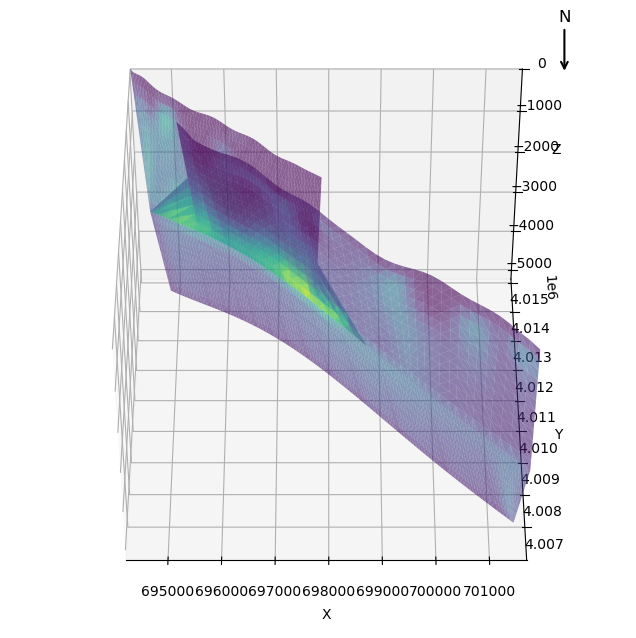

## Results

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
projfolder = '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/'


In [5]:
# Save positions
triangles = np.load(projfolder+'GIS/FinalFaultGeomFiles/tris_xyz.npy')

centroids = []
for triangle in triangles:
    # Calculate midpoints of each side
    midpoints = [(triangle[i] + triangle[(i + 1) % 3]) / 2 for i in range(3)]
    # Find centroid
    centroid = np.mean(midpoints, axis=0)
    centroids.append(centroid)
centroids = np.array(centroids)

colid = np.where(centroids[:,-1]>-5000)[0]

triangles = triangles[colid]


In [6]:
import matplotlib.tri as tri


In [8]:
fault = pd.read_csv(projfolder+f'SlipInversion/CentroidsWSlip_250mlengthscale_0.01alpha_0.1d2weights.csv')
disp = pd.read_csv(projfolder+f'SlipInversion/ModObsDisp250mlengthscale_0001alpha_0.1d2weights.csv')


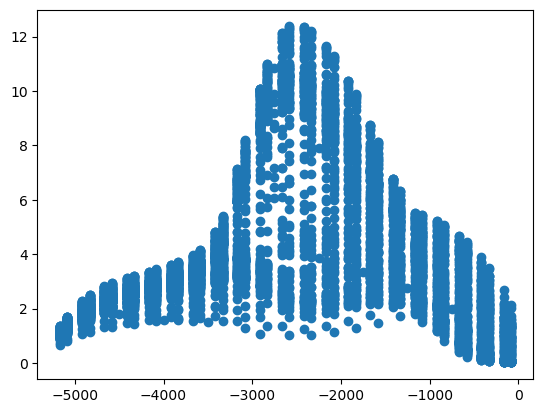

In [13]:
plt.scatter(fault.z,fault.strike_slip)

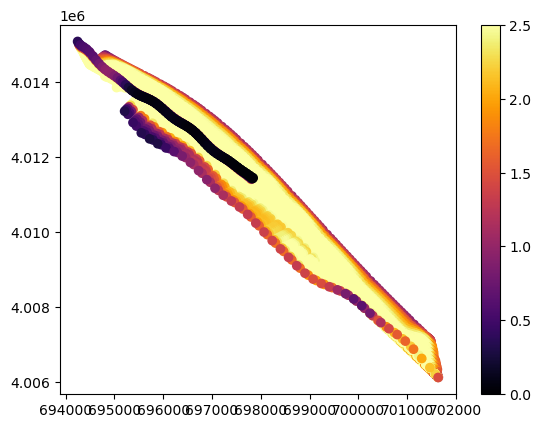

In [38]:
plt.scatter(fault.e,fault.n,c=fault.strike_slip,vmin=0,vmax=2.5,cmap='inferno')
plt.colorbar()

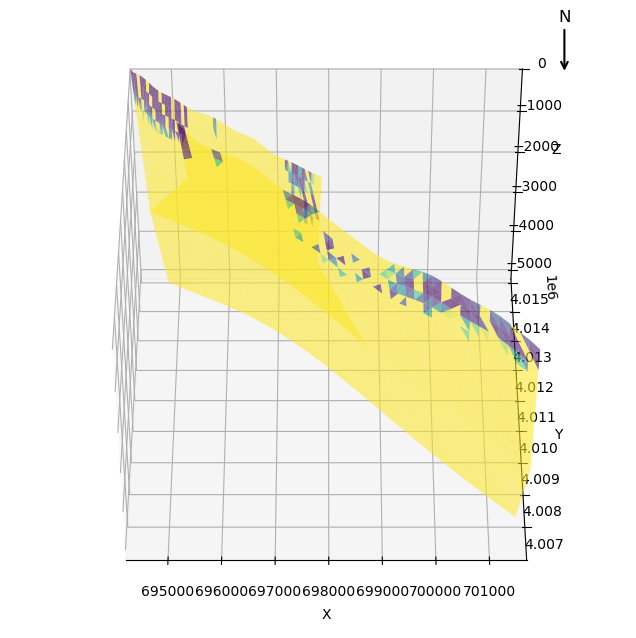

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# Save positions
triangles = np.load(projfolder+'GIS/FinalFaultGeomFiles/tris_xyz.npy')

centroids = []
for triangle in triangles:
    # Calculate midpoints of each side
    midpoints = [(triangle[i] + triangle[(i + 1) % 3]) / 2 for i in range(3)]
    # Find centroid
    centroid = np.mean(midpoints, axis=0)
    centroids.append(centroid)
centroids = np.array(centroids)

colid = np.where(centroids[:,-1]>-5000)[0]

triangles = triangles[colid]
# Extract vertices for plotting
x = triangles[:, :, 0].flatten()
y = triangles[:, :, 1].flatten()
z = triangles[:, :, 2].flatten()

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalize strike-slip values to a colormap
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0, vmax=30)

# Add a north arrow
arrow_start = [0.9, 0.9]  # Relative position in axes coordinates (top-right corner)
arrow_dx, arrow_dy = 0.0, 0.08  # Direction of the arrow (N points upward)
arrow_text = "N"  # Arrow label

# Add the arrow using an annotation
ax.annotate(
    arrow_text,
    xy=arrow_start,
    xytext=(arrow_start[0], arrow_start[1] + arrow_dy),
    xycoords="axes fraction",
    textcoords="axes fraction",
    arrowprops=dict(facecolor='black', arrowstyle="->", lw=1.5),
    fontsize=12,
    color="black",
    ha="center",
    va="bottom"
)

# Add triangles to the plot
for slip,tri in zip(fault.strike_slip*100,triangles):
    color = cmap(norm(slip))
    poly = Poly3DCollection([tri], alpha=0.6,facecolor=color)
    ax.add_collection3d(poly)

# Set axis limits (adjust as needed)
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(y), np.max(y))
ax.set_zlim(np.min(z), np.max(z))

# Set labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Specify view angle
ax.view_init(elev=45, azim=-90)  # Adjust elev and azim for desired view

# Show plot
plt.show()


In [58]:
import vtk

colors = fault.strike_slip#*100  # Scalar values for each triangle

# Create a VTK Points object to store vertices
points = vtk.vtkPoints()
vertices = triangles.reshape(-1, 3)  # Flatten triangle vertices to unique points

# Map unique vertices to indices
unique_vertices, inverse_indices = np.unique(vertices, axis=0, return_inverse=True)

# Add unique vertices to VTK Points
for vertex in unique_vertices:
    points.InsertNextPoint(vertex)

# Create a VTK CellArray to store the triangles
cells = vtk.vtkCellArray()

# Add each triangle to the CellArray
for tri_indices in inverse_indices.reshape(-1, 3):
    triangle = vtk.vtkTriangle()
    for i, idx in enumerate(tri_indices):
        triangle.GetPointIds().SetId(i, idx)
    cells.InsertNextCell(triangle)

# Create a VTK PolyData object
polydata = vtk.vtkPolyData()
polydata.SetPoints(points)
polydata.SetPolys(cells)

# Add scalar values (colors) as cell data
color_array = vtk.vtkFloatArray()
color_array.SetName("Colors")  # Name of the scalar field
color_array.SetNumberOfComponents(1)

for color in colors:
    color_array.InsertNextValue(color)

polydata.GetCellData().SetScalars(color_array)

# Write to a VTK file
writer = vtk.vtkXMLPolyDataWriter()
writer.SetFileName(projfolder+"SlipInversion/triangular_mesh.vtp")
writer.SetInputData(polydata)
writer.Write()

print("Mesh exported to triangular_mesh.vtp")


Mesh exported to triangular_mesh.vtp


In [3]:
m

NameError: name 'm' is not defined

In [1]:
def calculate_triangle_areas(triangles):
    """
    Calculate the areas of triangles given as an array with shape (N, 3, 3).

    Parameters:
        triangles (numpy.ndarray): An array of shape (N, 3, 3) where N is the
                                    number of triangles, and each triangle has
                                    3 vertices in 3D space (x, y, z).

    Returns:
        numpy.ndarray: An array of shape (N,) containing the area of each triangle.
    """
    # Extract vertices
    p1 = triangles[:, 0, :]  # First vertex of each triangle
    p2 = triangles[:, 1, :]  # Second vertex of each triangle
    p3 = triangles[:, 2, :]  # Third vertex of each triangle

    # Compute vectors for two edges of the triangle
    edge1 = p2 - p1
    edge2 = p3 - p1

    # Compute the cross product of the two edge vectors
    cross_product = np.cross(edge1, edge2)

    # Compute the magnitude of the cross product and divide by 2
    areas = np.linalg.norm(cross_product, axis=1) / 2

    return areas

areas = calculate_triangle_areas(triangles)
fault['area'] = areas



NameError: name 'triangles' is not defined

In [57]:
print('average slip per m2:',np.sum(fault.strike_slip*fault.area)/np.sum(fault.area)*100,'cm')

average slip per m2: 4.636451757130893 cm


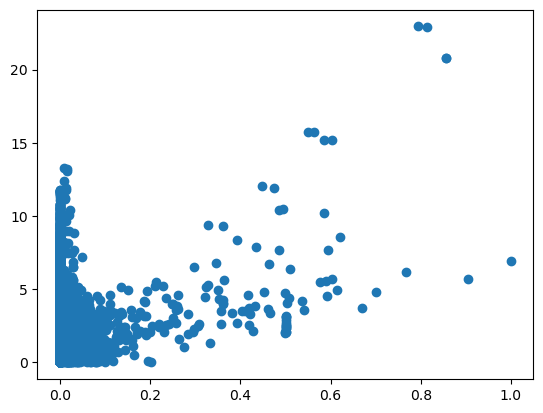

In [39]:
plt.scatter(fault.area/1000**2,fault.strike_slip*100)

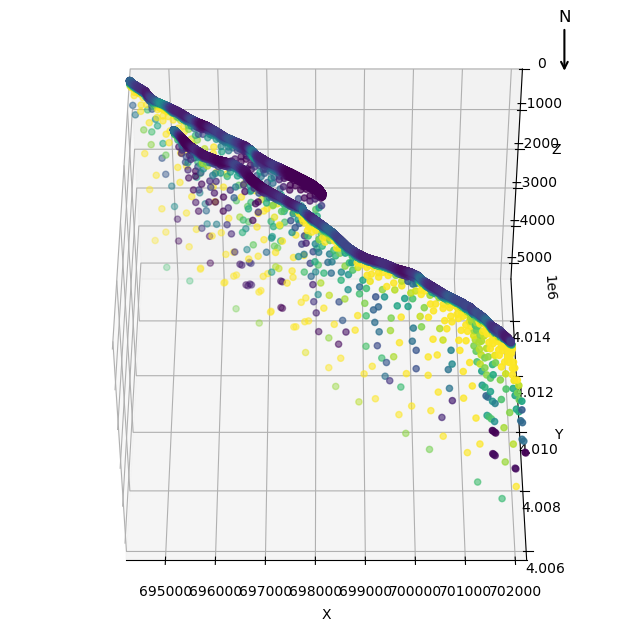

In [298]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Extract vertices for plotting
x = triangles[:, :, 0].flatten()
y = triangles[:, :, 1].flatten()
z = triangles[:, :, 2].flatten()

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalize strike-slip values to a colormap
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0, vmax=3)

# Add a north arrow
arrow_start = [0.9, 0.9]  # Relative position in axes coordinates (top-right corner)
arrow_dx, arrow_dy = 0.0, 0.08  # Direction of the arrow (N points upward)
arrow_text = "N"  # Arrow label

# Add the arrow using an annotation
ax.annotate(
    arrow_text,
    xy=arrow_start,
    xytext=(arrow_start[0], arrow_start[1] + arrow_dy),
    xycoords="axes fraction",
    textcoords="axes fraction",
    arrowprops=dict(facecolor='black', arrowstyle="->", lw=1.5),
    fontsize=12,
    color="black",
    ha="center",
    va="bottom"
)

# Add points to the plot
ax.scatter(fault.x,fault.y,fault.z,c=fault.strike_slip*100,vmin=0,vmax=3)

# Set axis limits (adjust as needed)
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(y), np.max(y))
ax.set_zlim(np.min(z), np.max(z))

# Set labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Specify view angle
ax.view_init(elev=45, azim=-90)  # Adjust elev and azim for desired view

# Show plot
plt.show()

## Look at mapped 

In [25]:
0.5*0.33


0.165

## Old

In [3]:
import pandas as pd
import numpy as np
from osgeo import gdal
import rioxarray
#import pygmt
import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt

In [2]:
df = pd.read_csv('bigdispl.txt',index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'bigdispl.txt'

In [4]:
im = rioxarray.open_rasterio('/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/23SEP05214604-P1BS_R3C1-merged.tif')
gdalim = gdal.Open('/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/23SEP05214604-P1BS_R3C1-merged.tif')
imgrid = np.meshgrid(im.x.data,im.y.data)

/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [5]:
bounds = tt.getOutputBounds(gdalim)
proj = im.spatial_ref.crs_wkt

In [ ]:
Dont rerun
gridX = pygmt.xyz2grd(x=df.x.values,y=df.y.values,z=df.dx.values,
                      spacing=[0.5],
                      region=[bounds[0],bounds[2],bounds[3],bounds[1]])
gridXinterp = gridX.interpolate_na(dim='x',method='slinear').interpolate_na(dim='y',method='slinear')
gridXinterp.rio.to_raster(projfolder+'Deformation/EastdX-rio.tif',spatial_ref=proj,driver='Gtiff')


In [ ]:
Dont rerun
gridY = pygmt.xyz2grd(x=df.x.values,y=df.y.values,z=df.dy.values,
                      spacing=[0.5],
                      region=[bounds[0],bounds[2],bounds[3],bounds[1]])
gridYinterp = gridY.interpolate_na(dim='x',method='slinear').interpolate_na(dim='y',method='slinear')
gridYinterp.rio.to_raster(projfolder+'Deformation/EastdY-rio.tif',spatial_ref=proj)


In [ ]:
Dont rerun
gridZ = pygmt.xyz2grd(x=df.x.values,y=df.y.values,z=df.dz.values,
                      spacing=[0.5],
                      region=[bounds[0],bounds[2],bounds[3],bounds[1]])
gridZinterp = gridZ.interpolate_na(dim='x',method='slinear').interpolate_na(dim='y',method='slinear')
gridZinterp.rio.to_raster(projfolder+'Deformation/EastdZ-rio.tif',spatial_ref=proj)


In [24]:
Dont rerun
# Make z deformation larger
imz = rioxarray.open_rasterio('/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/EastdZ-rio.tif')
imz = imz*4
imz.rio.to_raster('/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/EastdZ-rio-x4.tif',spatial_ref='EPSG:32611')



In [22]:
#!gdal_edit.py -a_srs EPSG:32611 /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdZ-rio.tif
#!gdal_edit.py -a_srs EPSG:32611 /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdX-rio.tif
#!gdal_edit.py -a_srs EPSG:32611 /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdY-rio.tif

In [6]:
projfolder = '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/'

In [7]:
imx = rioxarray.open_rasterio(projfolder+'EastdX-rio.tif')
imy = rioxarray.open_rasterio(projfolder+'EastdY-rio.tif')
imz = rioxarray.open_rasterio(projfolder+'EastdZ-rio-x4.tif')
#imelev = rioxarray.open_rasterio(projfolder+'metashape/EastProducts/dems/2023GarlockEastDEM-cropped.tif)
imgrid = np.meshgrid(imx.x,imx.y)

In [8]:
# y coords are flipped about the x-axis from the orthophoto coords
dx = imx.data[0]
dy = imy.data[0]
dz = imz.data[0] 

In [9]:
# Sample points at deformed locations
newx = imgrid[0]-dx
newy = imgrid[1]-dy
new_points = np.column_stack([newx.flatten(),newy.flatten()])
old_points = np.column_stack([imgrid[0].flatten(),imgrid[1].flatten()])

# Identify rows containing NaN entries
nan_indices = np.isnan(new_points).any(axis=1)

# Drop rows with NaN entries
points_without_nan = new_points[~nan_indices]
old_points_without_nan = old_points[~nan_indices]

In [ ]:
# see interpolation; Default uses “natural” conditions (second partial derivative normal to edge is zero) unless the grid is automatically recognized as periodic.
deformed1 = pygmt.grdtrack(projfolder+'micmac/23SEP05214604-P1BS_R3C1-merged.tif',
                          points=points_without_nan,no_skip=True)
deformed2 = pygmt.grdtrack(projfolder+'micmac/23SEP05214655-P1BS_R3C1-merged.tif',
                          points=points_without_nan,no_skip=True)
# DEM
deformedDEM = pygmt.grdtrack(projfolder+'micmac/2023GarlockEastDEM-cropped.tif',
                          points=points_without_nan,no_skip=True)

In [ ]:
deformed1.columns = ['x','y','vals']
deformed2.columns = ['x','y','vals']
deformedDEM.columns = ['x','y','vals']

In [ ]:
deformed1['oldx'] = old_points_without_nan[:,0]
deformed1['oldy'] = old_points_without_nan[:,1]
deformed2['oldx'] = old_points_without_nan[:,0]
deformed2['oldy'] = old_points_without_nan[:,1]
deformedDEM['oldx'] = old_points_without_nan[:,0]
deformedDEM['oldy'] = old_points_without_nan[:,1]

In [ ]:
deformed1Grid = pygmt.xyz2grd(x=deformed1.oldx.values,y=deformed1.oldy.values,z=deformed1.vals.values,
                      spacing='0.5/0.5',
                      region=[bounds[0],bounds[2],bounds[3],bounds[1]])
deformed2Grid = pygmt.xyz2grd(x=deformed2.oldx.values,y=deformed2.oldy.values,z=deformed2.vals.values,
                      spacing='0.5/0.5',
                      region=[bounds[0],bounds[2],bounds[3],bounds[1]])
deformedDEMGrid = pygmt.xyz2grd(x=deformedDEM.oldx.values,y=deformedDEM.oldy.values,z=deformedDEM.vals.values,
                      spacing='0.5/0.5',
                      region=[bounds[0],bounds[2],bounds[3],bounds[1]])
deformedDEMGrid += dz # add in vertcal def

In [11]:
import pygmt

In [ ]:
deformed1Grid.rio.to_raster(projfolder+'Deformation/2023deformed04ortho-rio.tif',spatial_ref=proj)
deformed2Grid.rio.to_raster(projfolder+'Deformation/2023deformed55ortho-rio.tif',spatial_ref=proj)
deformedDEMGrid.rio.to_raster(projfolder+'Deformation/2023deformedDEM-rio.tif',spatial_ref=proj)

In [26]:
# Change data type
#!gdalwarp -overwrite -r near -ot Float32 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/20APR28214017-P1BS_R3C1-merged.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/20APR28214017-P1BS_R3C1-merged-f32.tif
#!gdalwarp -overwrite -r near -ot Float32 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/20APR28214111-P1BS_R3C1-merged.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/20APR28214111-P1BS_R3C1-merged-f32.tif
#!gdalwarp -overwrite -r near -ot Float32 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/2023deformed04ortho-rio.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/2023deformed04ortho-rio-f32.tif
#!gdalwarp -overwrite -r near -ot Float32 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/2023deformed55ortho-rio.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/2023deformed55ortho-rio-f32.tif
#!gdalwarp -overwrite -r near -ot Float32 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped.tif  /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32.tif 
!gdalwarp -overwrite -r near -ot Float32 -of GTiff -s_srs EPSG:32611 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2023deformedDEM-rio.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2023deformedDEM-rio-f32.tif
#!gdalwarp -overwrite -r near -ot Float32 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/23SEP05214604-P1BS_R3C1-merged.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/23SEP05214604-P1BS_R3C1-merged-f32.tif 




python(72801) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Creating output file that is 22808P x 19130L.
Processing /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/2023deformedDEM-rio.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


# MicMac Post Processing

In [14]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import pygmt
#from pyproj import Proj, Geod
from osgeo import gdal

import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt

# reload modules when changed
%reload_ext autoreload
%autoreload 2


In [15]:
folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/'

In [16]:
predem = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32.tif'

In [ ]:
Don't Rerun unless necessary
# EW, NS, Correl file creation, and Parallel and Perpendicular
for fold in ['defaultsMEC1','defaultsMEC2','defaultsMEC3','defaultsMEC4','defaultsMECtest','defaultsMECdem']:
    tt.micmacPostProcessing(folder=folder+fold+'/',
                         prefile=predem,
                         outprefix=folder+fold+'/')
    
    #par, perp = tt.projectDisp(folder+fold+'/'+'EWmicmac.tif',folder+fold+'/'+'NSmicmac.tif',268,mask=None,partif=folder+fold+'/'+'ParallelDisp.tif',perptif=folder+fold+'/'+'PerpendicularDisp.tif')

In [ ]:
infolderlist = []
for fold in ['defaultsMEC1/','defaultsMEC2/','defaultsMEC3/','defaultsMEC4/']:
    infolderlist.append(folder+fold)
print(infolderlist)

In [ ]:
Don't Rerun unless necessary
# Stack the displacement maps based on correlation score
tt.micmacStack(infolderlist,folder)

In [5]:
Don't Rerun unless necessary
# Create vertical displacement map from the stacked horizontal results
dem1file = predem
dem2file = folder+'2023deformedDEM-rio-f32.tif'
nsfile = folder+'NSDispStacked.tif'
ewfile = folder+'EWDispStacked.tif'

#tt.verticalDisp(dem1file,dem2file,nsfile,ewfile,outf='VerticalDisp.tif')


SyntaxError: unterminated string literal (detected at line 1) (2709610747.py, line 1)

In [ ]:
Don't Rerun unless necessary
# 4 Vertical maps, instead of one from stacked displacements
dem1file = predem
dem2file = folder+'2023deformedDEM-rio-f32.tif'
for fold in ['defaultsMEC1','defaultsMEC2','defaultsMEC3','defaultsMEC4','defaultsMECtest','defaultsMECdem']:
    nsfile = folder+fold+'/NSmicmac.tif'
    ewfile = folder+fold+'/EWmicmac.tif'
    tt.verticalDisp(dem1file,dem2file,nsfile,ewfile,outf=folder+fold+'/UDmicmac.tif')

In [ ]:
Don't Rerun unless necessary
# One stacked Vertical map
tt.micmacStackUD(infolderlist,folder)

In [ ]:
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349 -r near -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/EWDispStacked.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/EWDispStackedEPSG4326.tif
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349 -r near -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/NSDispStacked.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/NSDispStackedEPSG4326.tif
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349  -r near -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/UDDispStacked.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/UDDispStackedEPSG4326.tif

#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349  -r near -of GTiff /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32EPSG4326.tif
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349  -r near -of GTiff /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2023deformedDEM-rio-f32.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2023deformedDEM-rio-f32EPSG4326.tif

#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349 -r near -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdX-rio.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdX-rioEPSG4326.tif
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349 -r near -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdY-rio.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdY-rioEPSG4326.tif
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349  -r near -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdZ-rio.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdZ-rioEPSG4326.tif

#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349  -r near -of GTiff /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/EastdZ-rio-x4.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/EastdZ-rio-x4EPSG4326.tif

#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349  -r near -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/CorrelStacked.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/CorrelStackedEPSG4326.tif



Creating output file that is 25061P x 16759L.
Processing /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/EastdZ-rio-x4.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


# Denoise and filter

In [2]:
from skimage.restoration import denoise_nl_means, estimate_sigma
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import pygmt
#from pyproj import Proj, Geod
from osgeo import gdal
from skimage.restoration import denoise_bilateral

import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt

# reload modules when changed
%reload_ext autoreload
%autoreload 2


In [3]:
import numpy as np
from scipy import signal

def apply_edge_window_2d(chunk, window_type='hann', edge_ratio=0.1):
    """
    Apply a window function to the edges of a 2D chunk to reduce edge effects.
    """
    rows, cols = chunk.shape
    window_rows = int(rows * edge_ratio)
    window_cols = int(cols * edge_ratio)

    if window_type == 'hann':
        window_row = np.hanning(2 * window_rows)
        window_col = np.hanning(2 * window_cols)
    elif window_type == 'hamming':
        window_row = np.hamming(2 * window_rows)
        window_col = np.hamming(2 * window_cols)
    else:
        raise ValueError(f"Unsupported window type: {window_type}")

    window_row = np.concatenate([window_row[:window_rows], np.ones(rows - 2 * window_rows), window_row[window_rows:]])
    window_col = np.concatenate([window_col[:window_cols], np.ones(cols - 2 * window_cols), window_col[window_cols:]])

    window_2d = np.outer(window_row, window_col)
    windowed_chunk = chunk * window_2d

    return windowed_chunk

def create_filter(filter_type, cutoff_low, cutoff_high):
    """
    Create a Butterworth filter based on the specified type and cutoff frequencies.
    """
    if filter_type == 'high':
        b, a = signal.butter(4, cutoff_high, btype='high')
    elif filter_type == 'low':
        b, a = signal.butter(4, cutoff_low, btype='low')
    elif filter_type == 'band':
        b, a = signal.butter(4, [cutoff_low, cutoff_high], btype='band')
    else:
        raise ValueError(f"Unsupported filter type: {filter_type}")
    return b, a

def process_image(image, row_filter_type='band', row_cutoff_low=0.001, row_cutoff_high=0.1,
                  col_filter_type='band', col_cutoff_low=0.001, col_cutoff_high=0.1,
                  stripw=1000, window_type='hann', edge_ratio=0.1):
    """
    Process the image to remove satellite stripes and waves while preserving
    long-wavelength fault deformation and near-fault offsets.
    
    Parameters:
        image (np.array): 2D image array.
        row_filter_type (str): Type of filter to apply on rows ('high', 'low', 'band').
        row_cutoff_low (float): Low cutoff frequency for row filtering.
        row_cutoff_high (float): High cutoff frequency for row filtering.
        col_filter_type (str): Type of filter to apply on columns ('high', 'low', 'band').
        col_cutoff_low (float): Low cutoff frequency for column filtering.
        col_cutoff_high (float): High cutoff frequency for column filtering.
        stripw (int): Width of strips for processing.
        window_type (str): Type of window function to apply ('hann', 'hamming').
        edge_ratio (float): Fraction of the strip edges to apply windowing.
    
    Returns:
        np.array: Filtered image.
    """
    # Create the filters for rows and columns
    if row_filter_type is not None:
        b_row, a_row = create_filter(row_filter_type, row_cutoff_low, row_cutoff_high)
    if col_filter_type is not None:
        b_col, a_col = create_filter(col_filter_type, col_cutoff_low, col_cutoff_high)

    # NAN mask
    mask = ((np.abs(image) > 10) & (np.isnan(image)))
    image[mask] = 0

    # Initialize arrays to store filtered results
    chunk_filtered_col = np.zeros_like(image)
    chunk_filtered_row = np.zeros_like(image)
    
    if row_filter_type is not None:
        # Process the image in chunks of stripw rows at a time
        for start_row in range(0, image.shape[0], int(stripw/4)): # shifting by half of the strip width
            end_row = min(start_row + stripw, image.shape[0])
            chunk = image[start_row:end_row, :]

            # Apply windowing to the chunk to reduce edge effects
            chunk = apply_edge_window_2d(chunk, window_type, edge_ratio)

            # Sum along columns for this chunk
            signal_row = np.sum(chunk, axis=0)
            

            # Apply the chosen filter to remove stripes/waves
            filter_row = signal.filtfilt(b_row, a_row, signal_row)

            # Subtract the filtered signal from each row in the chunk
            chunk_filtered_row[start_row:end_row, :] = filter_row[np.newaxis, :] / (end_row - start_row)

    if col_filter_type is not None:
        # Process the image in chunks of stripw columns at a time
        for start_col in range(0, image.shape[1], int(stripw/4)):
            end_col = min(start_col + stripw, image.shape[1])
            chunk = image[:, start_col:end_col]

            # Apply windowing to the chunk to reduce edge effects
            chunk = apply_edge_window_2d(chunk.T, window_type, edge_ratio).T

            # Sum along rows for this chunk
            signal_col = np.sum(chunk, axis=1)
            signal_col[np.isnan(signal_col)] = 0

            # Apply the chosen filter to remove stripes/waves
            filter_col = signal.filtfilt(b_col, a_col, signal_col)

            # Subtract the filtered signal from each column in the chunk
            chunk_filtered_col[:, start_col:end_col] = filter_col[:, np.newaxis] / (end_col - start_col)

    # Combine the results to get the final filtered image
    filtered_image = image - chunk_filtered_row - chunk_filtered_col

    # Handle any remaining NANs or zeros
    filtered_image[mask] = np.nan

    return filtered_image

In [4]:
folder = '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/'


In [ ]:
inlist2 = [folder+'EWDispStackedEPSG4326.tif',
    folder+'NSDispStackedEPSG4326.tif']
    #folder+'UDDispStackedEPSG4326.tif']
inlist2 = [folder+'defaultsMECdem/EWmicmacEPSG4326.tif',
    folder+'defaultsMECdem/NSmicmacEPSG4326.tif']
    #folder+'UDDispStackedEPSG4326.tif']

for file in inlist2[-1:]:
    im = gdal.Open(file)
    imdata = im.GetRasterBand(1).ReadAsArray()
    imdata[np.isnan(imdata)] = 0
    
    denoise = denoise_bilateral(imdata, sigma_color=None, sigma_spatial=8, bins=10000, mode='edge')

    print('Bandpass filtering')
    filtered = process_image(denoise, row_filter_type='band', row_cutoff_low=0.001, row_cutoff_high=0.1,
                      col_filter_type=None, col_cutoff_low=0.001, col_cutoff_high=0.01,
                      stripw=1000, window_type='hann', edge_ratio=0.1)
    
    #tt.save_geotiff(filtered,f'/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/{file[-20:-4]}_bidenoise_filtered.tif',im.GetGeoTransform(),im.GetProjection())


Bandpass filtering


In [20]:
#!gdalwarp -t_srs EPSG:32611 -overwrite -te 497678.532 3935139.907 509063.532 3944461.407 -tr 0.5 -0.5 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/NSDispStackedEPSG4326_bidenoise_filtered.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/NSDispStackedEPSG32611_bidenoise_filtered.tif
#!gdalwarp -t_srs EPSG:32611 -overwrite -te 497678.532 3935139.907 509063.532 3944461.407 -tr 0.5 -0.5 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/EWDispStackedEPSG4326_bidenoise_filtered.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/EWDispStackedEPSG32611_bidenoise_filtered.tif
#!gdalwarp -t_srs EPSG:32611 -overwrite -te 497678.532 3935139.907 509063.532 3944461.407 -tr 0.5 -0.5 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/EWmicmacEPSG4326_bidenoise_filtered.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/EWmicmacEPSG32611_bidenoise_filtered.tif
#!gdalwarp -t_srs EPSG:32611 -overwrite -te 497678.532 3935139.907 509063.532 3944461.407 -tr 0.5 -0.5 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/NSmicmacEPSG4326_bidenoise_filtered.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/NSmicmacEPSG32611_bidenoise_filtered.tif

!gdalwarp -t_srs EPSG:32611 -overwrite -te 497678.532 3935139.907 509063.532 3944461.407 -tr 0.5 -0.5 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32a.tif
!gdalwarp -t_srs EPSG:32611 -overwrite -te 497678.532 3935139.907 509063.532 3944461.407 -tr 0.5 -0.5 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2023deformedDEM-rio-f32.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2023deformedDEM-rio-f32a.tif


Creating output file that is 22770P x 18643L.
Using internal nodata values (e.g. 0) for image /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32.tif.
Copying nodata values from source /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32.tif to destination /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32a.tif.
Processing /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 22770P x 18643L.
Processing /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/2023deformedDEM-rio-f32.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [16]:
im = gdal.Open('/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/NSmicmacEPSG32611_bidenoise_filtered.tif')
bounds = tt.getOutputBounds(im)
print(np.round(bounds[0],3),np.round(bounds[3],3),np.round(bounds[2],3),np.round(bounds[1],3),sep=' ')

497678.532 3935139.907 509063.532 3944461.407


Creating output file that is 25188P x 16844L.
Copying nodata values from source /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/UDfromHDispStackedEPSG32611_bidenoise_filtered.tif to destination /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/UDfromHDispStackedEPSG4326_bidenoise_filtered.tif.
Processing /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/UDfromHDispStackedEPSG32611_bidenoise_filtered.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [18]:
# Recreate Vert map from filt result
# Create vertical displacement map from the stacked horizontal results
dem1file = folder+'2020GarlockEastDEM-cropped-f32a.tif'
dem2file = folder+'2023deformedDEM-rio-f32a.tif'
nsfile = folder+'defaultsMECdem/NSmicmacEPSG32611_bidenoise_filtered.tif'
ewfile = folder+'defaultsMECdem/EWmicmacEPSG32611_bidenoise_filtered.tif'


tt.verticalDisp(dem1file,dem2file,nsfile,ewfile,outf=folder+'defaultsMECdem/UDmicmacEPSG32611_bidenoise_filtered.tif')
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.025616 35.559928 -116.89999 35.6439349  -tr 4.987476808905901e-06 -4.987418543131882e-06 -srcnodata -9999 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/UDmicmacEPSG32611_bidenoise_filtered.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/UDmicmacEPSG4326_bidenoise_filtered.tif


array([[-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       ...,
       [-5.9960938e-01, -6.4569092e-01, -6.4538574e-01, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [-5.8514404e-01, -6.8115234e-01, -6.8353271e-01, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [-5.5346680e-01, -6.5698242e-01, -6.8164062e-01, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03]], dtype=float32)

In [19]:
# Recreate Vert map from filt result
# Create vertical displacement map from the stacked horizontal results
dem1file = folder+'2020GarlockEastDEM-cropped-f32.tif'
dem2file = folder+'2023deformedDEM-rio-f32.tif'
nsfile = folder+'NSDispStackedEPSG32611_bidenoise_filtered.tif'
ewfile = folder+'EWDispStackedEPSG32611_bidenoise_filtered.tif'


tt.verticalDisp(dem1file,dem2file,nsfile,ewfile,outf=folder+'UDfromHDispStackedEPSG32611_bidenoise_filtered.tif')
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.025616 35.559928 -116.89999 35.6439349  -tr 4.987476808905901e-06 -4.987418543131882e-06 -srcnodata -9999 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/UDfromHDispStackedEPSG32611_bidenoise_filtered.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/UDfromHDispStackedEPSG4326_bidenoise_filtered.tif


ValueError: operands could not be broadcast together with shapes (18643,22770) (19129,22807) 

In [9]:
inlist2 = [folder+'defaultsMECdem/UDmicmacEPSG4326_bidenoise_filtered.tif',
           folder+'UDfromHDispStackedEPSG4326_bidenoise_filtered.tif']

for file in inlist2[:-1]:
    im = gdal.Open(file)
    # Create a copy of the raster in memory or save to a new file
    driver = gdal.GetDriverByName("MEM")  # Use "GTiff" to save to disk instead
    im_copy = driver.CreateCopy("", im, 0)  # "" for in-memory, or provide a file name

    # Get the band from the copy and fill NoData values
    band = im_copy.GetRasterBand(1)
    gdal.FillNodata(targetBand=band, maskBand=None, maxSearchDist=10000, smoothingIterations=0)

    # Access the modified array without saving
    filled_array = band.ReadAsArray()
    
    denoise = denoise_bilateral(filled_array, sigma_color=None, sigma_spatial=8, bins=10000, mode='edge')

    print('Bandpass filtering')
    filtered = process_image(denoise, row_filter_type='band', row_cutoff_low=0.001, row_cutoff_high=0.1,
                      col_filter_type=None, col_cutoff_low=0.001, col_cutoff_high=0.01,
                      stripw=1000, window_type='hann', edge_ratio=0.1)
   #if 'dem' in file:
    #    tt.save_geotiff(filtered,folder+'defaultsMECdem/UDfromHdispStackedEPSG4326_bidenoise_filtered_refiltered.tif',im.GetGeoTransform(),im.GetProjection())
    #else:
    #    tt.save_geotiff(filtered,folder+'UDfromHdispStackedEPSG4326_bidenoise_filtered_refiltered.tif',im.GetGeoTransform(),im.GetProjection())


Bandpass filtering


In [4]:
inlist2 = ['defaultsMECdem/UDmicmacEPSG4326_bidenoise_filtered.tif',
           'UDfromHDispStackedEPSG4326_bidenoise_filtered.tif']

for file in inlist2[:-1]:
    print(file)

defaultsMECdem/UDmicmacEPSG4326_bidenoise_filtered.tif


In [5]:
im = gdal.Open('/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/NSDispStackedEPSG4326_bidenoise_filtered.tif')
bounds = tt.getOutputBounds(im)
print(bounds[0],bounds[3],bounds[2],bounds[1],sep=' ')

-117.025616 35.559928 -116.89999 35.6439349


In [1]:
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.025616 35.559928 -116.89999 35.6439349  -tr 4.987476808905901e-06 -4.987418543131882e-06 -srcnodata -9999 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/UDfromHDispStackedEPSG32611_bidenoise_filtered_refiltered.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/UDfromHDispStackedEPSG4326_bidenoise_filtered_refiltered.tif
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.025616 35.559928 -116.89999 35.6439349  -tr 4.987476808905901e-06 -4.987418543131882e-06 -srcnodata -9999 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/UDfromHdispStackedEPSG32611_bidenoise_filtered_refiltered.tif  /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/UDfromHdispStackedEPSG4326_bidenoise_filtered_refiltered.tif
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.025616 35.559928 -116.89999 35.6439349  -tr 4.987476808905901e-06 -4.987418543131882e-06 -srcnodata -9999 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/CorrelmicmacEPSG4326.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/CorrelmicmacEPSG4326-clipped.tif

Creating output file that is 25188P x 16844L.
Copying nodata values from source /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/CorrelmicmacEPSG4326.tif to destination /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/CorrelmicmacEPSG4326-clipped.tif.
Processing /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/CorrelmicmacEPSG4326.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Creating output file that is 21560P x 15499L.
Copying nodata values from source /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/UDfromHdispStackedEPSG32611_bidenoise_filtered_refiltered.tif to destination /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/UDfromHdispStackedEPSG4326_bidenoise_filtered_refiltered.tif.
Processing /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/UDfromHdispStackedEPSG32611_bidenoise_filtered_refiltered.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


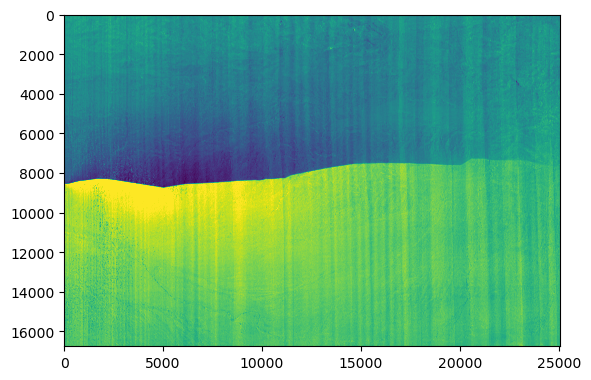

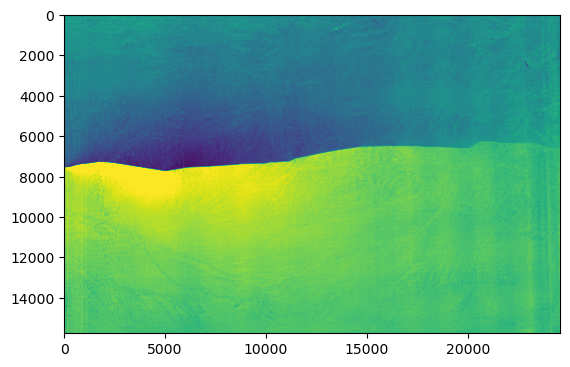

In [59]:
plt.imshow(imdata,vmin=-1,vmax=1)
plt.show()
plt.imshow(filtered,vmin=-1,vmax=1)

In [55]:
denoise[15750:16000,:]

array([[0.54504341, 0.54449081, 0.5441219 , ..., 0.16364394, 0.15658738,
        0.14900063],
       [0.54183741, 0.5409682 , 0.540294  , ..., 0.16425646, 0.15708895,
        0.14939457],
       [0.53889285, 0.53773858, 0.53677039, ..., 0.16488115, 0.15759288,
        0.14978041],
       ...,
       [0.50353314, 0.50250463, 0.50153108, ..., 0.1657265 , 0.15872238,
        0.15122852],
       [0.50537188, 0.5043455 , 0.50337131, ..., 0.16702726, 0.15994915,
        0.15237247],
       [0.50725701, 0.50623862, 0.50526488, ..., 0.16819004, 0.16104778,
        0.15340072]])

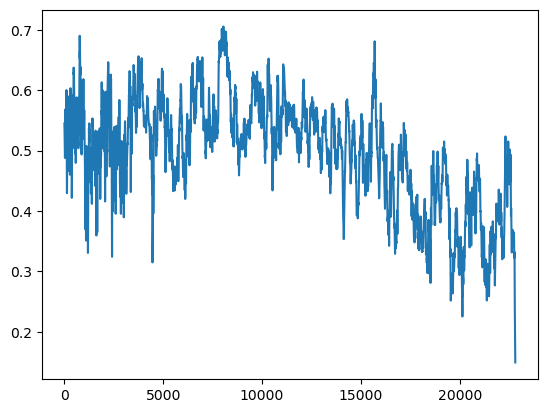

In [48]:
#plt.plot(filtered[15750,:])
plt.plot(denoise[15750,:])

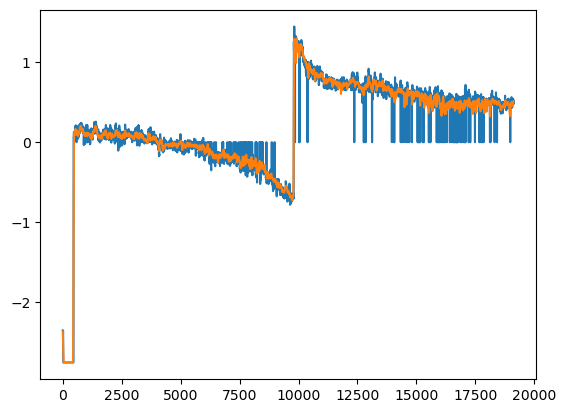

In [16]:
plt.plot(imdata[:,1000])
plt.plot(denoise[:,1000])

In [6]:
folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/'


In [14]:
tt.save_geotiff(denoise2_fast,file[:-17]+f'{file[-17:-4]}_filtered.tif',im.GetGeoTransform(),im.GetProjection())


In [16]:
# NL means then destriping
noisy = im2data

# estimate the noise standard deviation from the noisy image
sigma_est = np.mean(estimate_sigma(noisy))
print(f'estimated noise standard deviation = {sigma_est}')

# Note that increasing the nl_means patch size parameters increases run-time
patch_kw = dict(
    patch_size=100, patch_distance=12  # patch size (patch_size x patch_size) and search area (patchdistance+patchdistance+1)**2
)
print('Running NL means')
# fast algorithm, sigma provided
denoise2_fast = denoise_nl_means(
    noisy, h=0.7 * sigma_est, sigma=sigma_est, fast_mode=True, **patch_kw
)



estimated noise standard deviation = 0.00026825528863995
Running NL means


In [20]:
from skimage.restoration import denoise_bilateral
from skimage.filters import window, difference_of_gaussians

In [41]:
denoise2_fast = denoise_bilateral(im2data, sigma_color=None, sigma_spatial=8, bins=10000, mode='edge')

Bandpass filtering


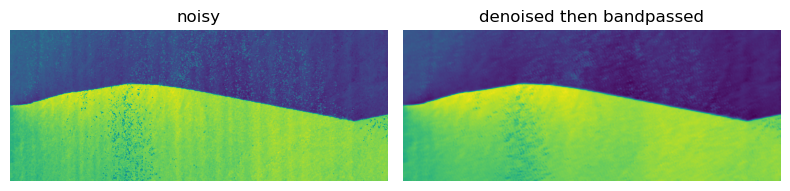

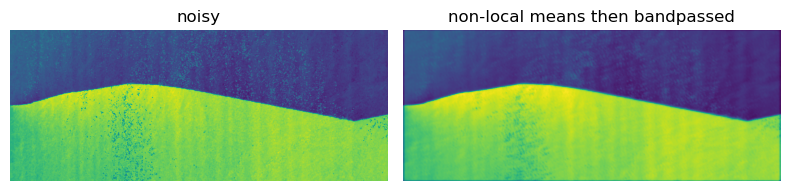

In [36]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6), sharex=True, sharey=True)

ax[0].imshow(im2data)
ax[0].axis('off')
ax[0].set_title('noisy')
ax[1].imshow(denoise2_fast)
ax[1].axis('off')
ax[1].set_title('non-local means then bandpassed')

fig.tight_layout()

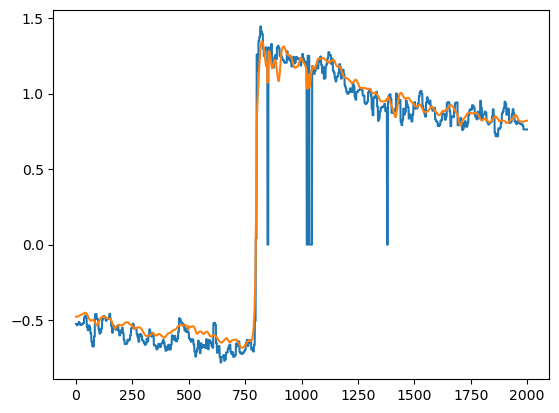

In [49]:
plt.plot(im2data[:,1000])
plt.plot(nl_filtered[:,1000])

## Filter

In [ ]:
from sklearn.decomposition import FastICA, PCA, IncrementalPCA
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt

# reload modules when changed
%reload_ext autoreload
%autoreload 2


folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/'

from pyproj import Proj, Geod
P = Proj('epsg:32611')
G = Geod(ellps='WGS84')


In [ ]:
im1 = gdal.Open(folder+'NSDispStacked.tif')
im1data = im1.GetRasterBand(1).ReadAsArray()#[500:,:]
im2 = gdal.Open(folder+'EWDispStacked.tif')
im2data = im2.GetRasterBand(1).ReadAsArray()#[500:,:]
im3 = gdal.Open(folder+'UDDispStacked.tif')
im3data = im3.GetRasterBand(1).ReadAsArray()#[500:,:]


In [ ]:
gt = im1.GetGeoTransform()
res = gt[1]
refimNodata = im1.GetRasterBand(1).GetNoDataValue()

In [26]:
import numpy as np
from scipy import signal

def apply_edge_window_2d(chunk, window_type='hann', edge_ratio=0.1):
    """
    Apply a window function to the edges of a 2D chunk to reduce edge effects.
    """
    rows, cols = chunk.shape
    window_rows = int(rows * edge_ratio)
    window_cols = int(cols * edge_ratio)

    if window_type == 'hann':
        window_row = np.hanning(2 * window_rows)
        window_col = np.hanning(2 * window_cols)
    elif window_type == 'hamming':
        window_row = np.hamming(2 * window_rows)
        window_col = np.hamming(2 * window_cols)
    else:
        raise ValueError(f"Unsupported window type: {window_type}")

    window_row = np.concatenate([window_row[:window_rows], np.ones(rows - 2 * window_rows), window_row[window_rows:]])
    window_col = np.concatenate([window_col[:window_cols], np.ones(cols - 2 * window_cols), window_col[window_cols:]])

    window_2d = np.outer(window_row, window_col)
    windowed_chunk = chunk * window_2d

    return windowed_chunk

def create_filter(filter_type, cutoff_low, cutoff_high):
    """
    Create a Butterworth filter based on the specified type and cutoff frequencies.
    """
    if filter_type == 'high':
        b, a = signal.butter(4, cutoff_high, btype='high')
    elif filter_type == 'low':
        b, a = signal.butter(4, cutoff_low, btype='low')
    elif filter_type == 'band':
        b, a = signal.butter(4, [cutoff_low, cutoff_high], btype='band')
    else:
        raise ValueError(f"Unsupported filter type: {filter_type}")
    return b, a

def process_image(image, row_filter_type='band', row_cutoff_low=0.001, row_cutoff_high=0.1,
                  col_filter_type='band', col_cutoff_low=0.001, col_cutoff_high=0.1,
                  stripw=1000, window_type='hann', edge_ratio=0.1):
    """
    Process the image to remove satellite stripes and waves while preserving
    long-wavelength fault deformation and near-fault offsets.
    
    Parameters:
        image (np.array): 2D image array.
        row_filter_type (str): Type of filter to apply on rows ('high', 'low', 'band').
        row_cutoff_low (float): Low cutoff frequency for row filtering.
        row_cutoff_high (float): High cutoff frequency for row filtering.
        col_filter_type (str): Type of filter to apply on columns ('high', 'low', 'band').
        col_cutoff_low (float): Low cutoff frequency for column filtering.
        col_cutoff_high (float): High cutoff frequency for column filtering.
        stripw (int): Width of strips for processing.
        window_type (str): Type of window function to apply ('hann', 'hamming').
        edge_ratio (float): Fraction of the strip edges to apply windowing.
    
    Returns:
        np.array: Filtered image.
    """
    # Create the filters for rows and columns
    if row_filter_type is not None:
        b_row, a_row = create_filter(row_filter_type, row_cutoff_low, row_cutoff_high)
    if col_filter_type is not None:
        b_col, a_col = create_filter(col_filter_type, col_cutoff_low, col_cutoff_high)

    # NAN mask
    mask = ((np.abs(image) > 10) & (np.isnan(image)))
    image[mask] = 0

    # Initialize arrays to store filtered results
    chunk_filtered_col = np.zeros_like(image)
    chunk_filtered_row = np.zeros_like(image)
    
    if row_filter_type is not None:
        # Process the image in chunks of stripw rows at a time
        for start_row in range(0, image.shape[0], int(stripw/4)): # shifting by half of the strip width
            end_row = min(start_row + stripw, image.shape[0])
            chunk = image[start_row:end_row, :]

            # Apply windowing to the chunk to reduce edge effects
            chunk = apply_edge_window_2d(chunk, window_type, edge_ratio)

            # Sum along columns for this chunk
            signal_row = np.sum(chunk, axis=0)
            

            # Apply the chosen filter to remove stripes/waves
            filter_row = signal.filtfilt(b_row, a_row, signal_row)

            # Subtract the filtered signal from each row in the chunk
            chunk_filtered_row[start_row:end_row, :] = filter_row[np.newaxis, :] / (end_row - start_row)

    if col_filter_type is not None:
        # Process the image in chunks of stripw columns at a time
        for start_col in range(0, image.shape[1], int(stripw/4)):
            end_col = min(start_col + stripw, image.shape[1])
            chunk = image[:, start_col:end_col]

            # Apply windowing to the chunk to reduce edge effects
            chunk = apply_edge_window_2d(chunk.T, window_type, edge_ratio).T

            # Sum along rows for this chunk
            signal_col = np.sum(chunk, axis=1)
            signal_col[np.isnan(signal_col)] = 0

            # Apply the chosen filter to remove stripes/waves
            filter_col = signal.filtfilt(b_col, a_col, signal_col)

            # Subtract the filtered signal from each column in the chunk
            chunk_filtered_col[:, start_col:end_col] = filter_col[:, np.newaxis] / (end_col - start_col)

    # Combine the results to get the final filtered image
    filtered_image = image - chunk_filtered_row - chunk_filtered_col

    # Handle any remaining NANs or zeros
    filtered_image[mask] = np.nan

    return filtered_image

In [ ]:
inlist = [folder+'defaultsMEC1/NSmicmac.tif',
    folder+'defaultsMEC3/NSmicmac.tif',
    folder+'defaultsMEC2/NSmicmac.tif',
    folder+'defaultsMEC4/NSmicmac.tif',
    folder+'defaultsMEC1/EWmicmac.tif',
    folder+'defaultsMEC3/EWmicmac.tif',
    folder+'defaultsMEC2/EWmicmac.tif',
    folder+'defaultsMEC4/EWmicmac.tif',
    folder+'defaultsMEC1/UDmicmac.tif',
    folder+'defaultsMEC3/UDmicmac.tif',
    folder+'defaultsMEC2/UDmicmac.tif',
    folder+'defaultsMEC4/UDmicmac.tif']

inlist2 = [folder+'EWDispStacked.tif',
    folder+'NSDispStacked.tif',
    folder+'UDDispStacked.tif']

In [ ]:
#Don't rerun unless necessary
## Filter all images
#for file in inlist:
#    im = gdal.Open(file)
#    imdata = im.GetRasterBand(1).ReadAsArray()
#    filtered = process_image(imdata, row_filter_type='band', row_cutoff_low=0.001, row_cutoff_high=0.1,
#                  col_filter_type='high', col_cutoff_low=0.001, col_cutoff_high=0.01,
#                  stripw=1000, window_type='hann', edge_ratio=0.1)
#    
#    # Save Files
#    tt.save_geotiff(filtered,file[:-12]+f'{file[-12:-4]}_filtered.tif',im.GetGeoTransform(),im.GetProjection())

for file in [inlist2[0]]:
    im = gdal.Open(file)
    imdata = im.GetRasterBand(1).ReadAsArray()
    filtered = process_image(imdata, row_filter_type='band', row_cutoff_low=0.001, row_cutoff_high=0.1,
                  col_filter_type=None, col_cutoff_low=0.001, col_cutoff_high=0.01,
                  stripw=1000, window_type='hann', edge_ratio=0.1)
    tt.save_geotiff(filtered,file[:-17]+f'{file[-17:-4]}_filtered2.tif',im.GetGeoTransform(),im.GetProjection())



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise


astro = img_as_float(data.astronaut())
astro = astro[30:180, 150:300,0]

sigma = 0.08
noisy = random_noise(astro, var=sigma**2)

# estimate the noise standard deviation from the noisy image
sigma_est = np.mean(estimate_sigma(noisy))
print(f'estimated noise standard deviation = {sigma_est}')

patch_kw = dict(
    patch_size=5, patch_distance=6, channel_axis=-1  # 5x5 patches  # 13x13 search area
)

# slow algorithm
denoise = denoise_nl_means(noisy, h=1.15 * sigma_est, fast_mode=False, **patch_kw)

# slow algorithm, sigma provided
denoise2 = denoise_nl_means(
    noisy, h=0.8 * sigma_est, sigma=sigma_est, fast_mode=False, **patch_kw
)

# fast algorithm
denoise_fast = denoise_nl_means(noisy, h=0.8 * sigma_est, fast_mode=True, **patch_kw)

# fast algorithm, sigma provided
denoise2_fast = denoise_nl_means(
    noisy, h=0.6 * sigma_est, sigma=sigma_est, fast_mode=True, **patch_kw
)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 6), sharex=True, sharey=True)

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('noisy')
ax[0, 1].imshow(denoise)
ax[0, 1].axis('off')
ax[0, 1].set_title('non-local means\n(slow)')
ax[0, 2].imshow(denoise2)
ax[0, 2].axis('off')
ax[0, 2].set_title('non-local means\n(slow, using $\\sigma_{est}$)')
ax[1, 0].imshow(astro)
ax[1, 0].axis('off')
ax[1, 0].set_title('original\n(noise free)')
ax[1, 1].imshow(denoise_fast)
ax[1, 1].axis('off')
ax[1, 1].set_title('non-local means\n(fast)')
ax[1, 2].imshow(denoise2_fast)
ax[1, 2].axis('off')
ax[1, 2].set_title('non-local means\n(fast, using $\\sigma_{est}$)')

fig.tight_layout()

# print PSNR metric for each case
psnr_noisy = peak_signal_noise_ratio(astro, noisy)
psnr = peak_signal_noise_ratio(astro, denoise)
psnr2 = peak_signal_noise_ratio(astro, denoise2)
psnr_fast = peak_signal_noise_ratio(astro, denoise_fast)
psnr2_fast = peak_signal_noise_ratio(astro, denoise2_fast)

print(f'PSNR (noisy) = {psnr_noisy:0.2f}')
print(f'PSNR (slow) = {psnr:0.2f}')
print(f'PSNR (slow, using sigma) = {psnr2:0.2f}')
print(f'PSNR (fast) = {psnr_fast:0.2f}')
print(f'PSNR (fast, using sigma) = {psnr2_fast:0.2f}')

plt.show()

In [ ]:
np.shape(noisy)

In [ ]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise



noisy = imdata - np.nanmin(imdata)
noisy[np.isnan(imdata)] = 0

# estimate the noise standard deviation from the noisy image
sigma_est = np.mean(estimate_sigma(noisy))
print(f'estimated noise standard deviation = {sigma_est}')

patch_kw = dict(
    patch_size=10, patch_distance=20  # 5x5 patches  # 13x13 search area
)

# fast algorithm, sigma provided
denoise2_fast = denoise_nl_means(noisy, h=sigma_est, sigma=sigma_est, fast_mode=True, **patch_kw)


In [ ]:
plt.imshow(denoise2_fast)
plt.show()
plt.imshow(noisy)

In [ ]:
plt.plot(denoise2_fast[:,100])
plt.plot(noisy[:,100])

In [ ]:
imx = rioxarray.open_rasterio(projfolder+'EastdX-rio.tif')
dx = np.flip(imx.data[0],axis=0)
efile = gdal.Open(folder+'EWDispStackedFiltered.tif')
edisp = efile.GetRasterBand(1).ReadAsArray()
cfile = gdal.Open(folder+'CorrelStacked.tif')
cdisp = cfile.GetRasterBand(1).ReadAsArray()


In [ ]:
res = ((dx[1:,1:]-np.nanmean(dx[1:,1:]))-(edisp-np.nanmean(edisp)))

In [ ]:
tt.save_geotiff(res,folder+'CorrelationResiduals.tif',efile.GetGeoTransform(),efile.GetProjection())

In [ ]:
boo = (cdisp.flatten() >=3.99)
p = res.flatten()[boo]
plt.hist(p,bins=100)
print(np.std(p))

In [ ]:
boo = (cdisp.flatten() >=3.75)
p = res.flatten()[boo]
plt.hist(p,bins=100)
print(np.std(p))

In [ ]:
boo = (cdisp.flatten() >=3)
p = res.flatten()[boo]
plt.hist(p,bins=100)
print(np.std(p))

In [ ]:
boo = ((cdisp.flatten() >=2)&(cdisp.flatten() < 3))
p = res.flatten()[boo]
plt.hist(p,bins=100)
print(np.std(p))

In [ ]:
boo = ((cdisp.flatten() >= 1) & (cdisp.flatten() < 2))
p = res.flatten()[boo]
plt.hist(p,bins=100)
print(np.std(p))

In [ ]:
boo = ((cdisp.flatten() > 0) & (cdisp.flatten() < 1))
p = res.flatten()[boo]
plt.hist(p,bins=100)
print(np.nanstd(p))

## Alt filter


In [ ]:
from sklearn.decomposition import FastICA, PCA, IncrementalPCA
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal


folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/'

from pyproj import Proj, Geod
P = Proj('epsg:32611')
G = Geod(ellps='WGS84')

In [ ]:
from scipy import signal

im = gdal.Open(folder+'NSDispStacked.tif')

imdata = im.GetRasterBand(1).ReadAsArray()[7500:12000,5000:10000]
imdata[np.isnan(imdata)] = 0

In [ ]:
plt.imshow(imdata)
plt.show()

## ICA ...?

In [2]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from osgeo import gdal

import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt

# reload modules when changed
%reload_ext autoreload
%autoreload 2

In [3]:
folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/'

In [ ]:
efile = gdal.Open(folder+'EWDispStackedFiltered.tif')
edisp = efile.GetRasterBand(1).ReadAsArray()[7000:12000,2000:10000]
nfile = gdal.Open(folder+'NSDispStackedFiltered.tif')
ndisp = nfile.GetRasterBand(1).ReadAsArray()[7000:12000,2000:10000]
ufile = gdal.Open(folder+'UDDispStackedFiltered.tif')
udisp = ufile.GetRasterBand(1).ReadAsArray()[7000:12000,2000:10000]
demfile = gdal.Open(folder+'2020GarlockEastDEM-cropped-f32.tif')
dem = demfile.GetRasterBand(1).ReadAsArray()[7000:12000,2000:10000]

In [4]:
inlist = [folder+'defaultsMEC1/NSmicmac_filtered.tif',
    folder+'defaultsMEC3/NSmicmac_filtered.tif',
    folder+'defaultsMEC2/NSmicmac_filtered.tif',
    folder+'defaultsMEC4/NSmicmac_filtered.tif',
    folder+'defaultsMEC1/EWmicmac_filtered.tif',
    folder+'defaultsMEC3/EWmicmac_filtered.tif',
    folder+'defaultsMEC2/EWmicmac_filtered.tif',
    folder+'defaultsMEC4/EWmicmac_filtered.tif',
    folder+'defaultsMEC1/UDmicmac_filtered.tif',
    folder+'defaultsMEC3/UDmicmac_filtered.tif',
    folder+'defaultsMEC2/UDmicmac_filtered.tif',
    folder+'defaultsMEC4/UDmicmac_filtered.tif']

inlist = [folder+'defaultsMEC1/NSmicmac.tif',
    folder+'defaultsMEC3/NSmicmac.tif',
    folder+'defaultsMEC2/NSmicmac.tif',
    folder+'defaultsMEC4/NSmicmac.tif']#,
    #folder+'defaultsMEC1/EWmicmac.tif',
    #folder+'defaultsMEC3/EWmicmac.tif',
    #folder+'defaultsMEC2/EWmicmac.tif',
    #folder+'defaultsMEC4/EWmicmac.tif',
    #folder+'defaultsMEC1/UDmicmac.tif',
    #folder+'defaultsMEC3/UDmicmac.tif',
    #folder+'defaultsMEC2/UDmicmac.tif',
    #folder+'defaultsMEC4/UDmicmac.tif']

filt = {}

for i,file in enumerate(inlist):
    im = gdal.Open(file)
    filt[str(i)] = im.GetRasterBand(1).ReadAsArray()

/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [ ]:
np.array((len(inlist)))

In [5]:
# Reshape and stack the images

shape = np.shape(filt['0'][9000:11000,0:5000])
im1data_reshaped = np.empty((int(shape[0]*shape[1]),len(inlist)))

for i in filt.keys(): 
    im1data_reshaped[:,int(i)] = filt[i][9000:11000,0:5000].flatten()



In [14]:
from sklearn.decomposition import FastICA, PCA

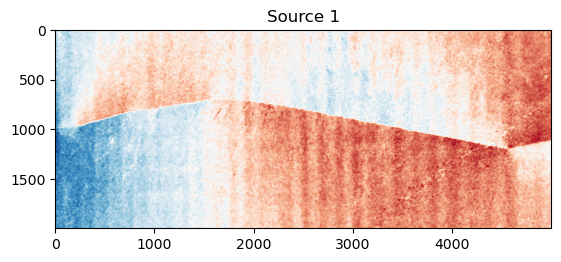

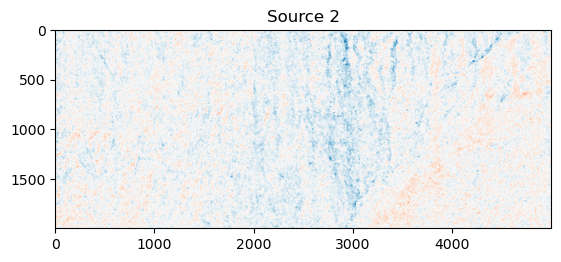

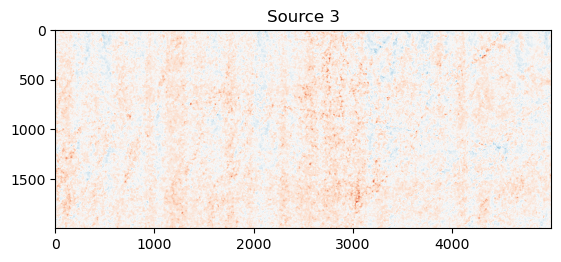

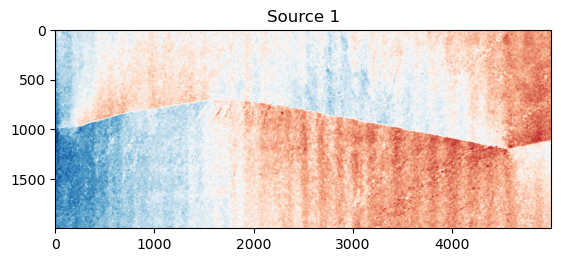

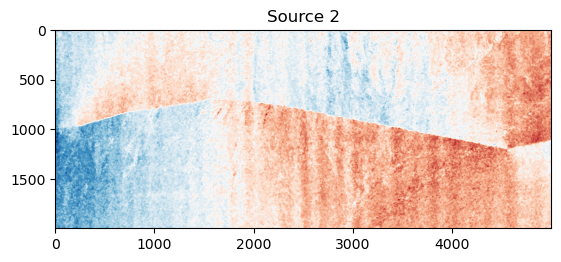

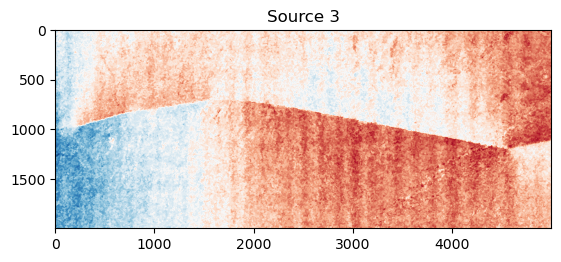

In [21]:
# Apply FastICA
pca = PCA(n_components=3,whiten=True,tol=1e-12)
S_ = pca.fit_transform(im1data_reshaped)  # estimated sources
#A_ = pca.mixing_  # estimated mixing matrix
#print("Estimated mixing matrix:\n{}".format(A_))
plt.Figure()
# Recover and visualize the sources
for i in range(S_.shape[1]):
    source = S_[:, i].reshape(shape[0], shape[1])
    plt.imshow(source, cmap='RdBu',vmin=np.min(source),vmax = np.max(source))
    plt.title(f'Source {i+1}')
    plt.show()


Estimated mixing matrix:
[[  63.37444531 -633.69959593  -62.95835261 -191.04197457]
 [  66.46389533 -681.62435325   34.74093885  -16.22459595]
 [-116.39031463 -608.39556701   61.88491563 -230.96990974]
 [-143.88746358 -644.44745744  -77.30473339  -66.71733938]]


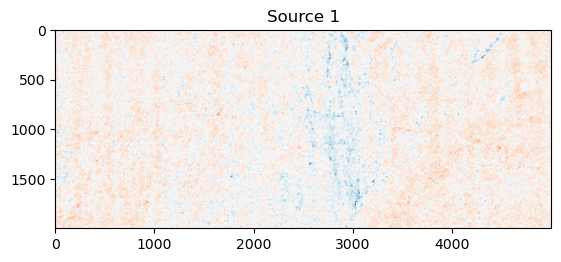

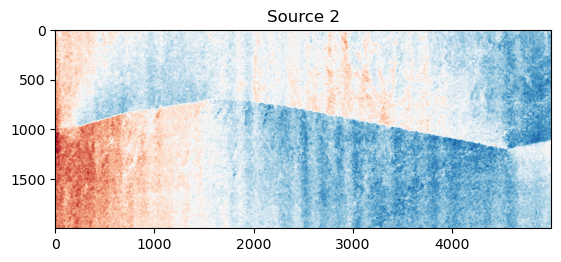

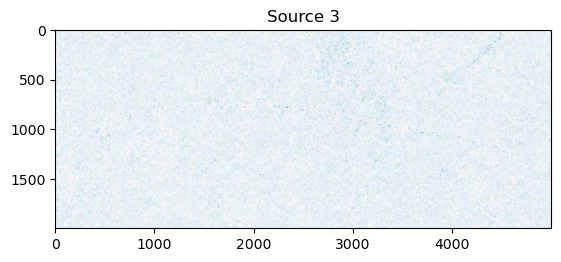

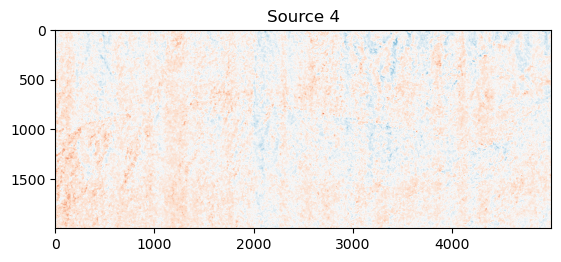

In [24]:
# Apply FastICA
ica = FastICA(n_components=4,fun='logcosh',whiten='arbitrary-variance',whiten_solver='eigh',max_iter=10000,tol=1e-12)
S_ = ica.fit_transform(im1data_reshaped)  # estimated sources
A_ = ica.mixing_  # estimated mixing matrix
print("Estimated mixing matrix:\n{}".format(A_))
plt.Figure()
# Recover and visualize the sources
for i in range(S_.shape[1]):
    source = S_[:, i].reshape(shape[0], shape[1])
    plt.imshow(source, cmap='RdBu',vmin=np.min(source),vmax = np.max(source))
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
# Reconstruct S to zero out the noise
denoised = S_[:,(1,2,4)]@A_[:,(1,2,4)].T
noise = S_[:,(0,3)]@A_[:,(0,3)].T
np.shape(denoised), np.shape(noise)

In [ ]:
icaU = denoised[:,8:12].reshape(shape[0],shape[1],4).sum(axis=2)/4
icaE = denoised[:,4:8].reshape(shape[0],shape[1],4).sum(axis=2)/4
icaN = denoised[:,0:4].reshape(shape[0],shape[1],4).sum(axis=2)/4

In [ ]:
n = filt['0'][9000:11000,0:5000]
e = filt['4'][9000:11000,0:5000]
u = filt['8'][9000:11000,0:5000]

In [ ]:
np.sqrt((np.max(n)-np.min(n))**2+(np.max(e)-np.min(n))**2), np.sqrt((np.max(icaN)-np.min(icaN))**2+(np.max(icaE)-np.min(icaE))**2)

In [ ]:
plt.imshow(icaN,vmin=-1,vmax=1)
plt.show()
plt.imshow(filt['0'][9000:11000,0:5000],vmin=-1,vmax=1)


In [ ]:
plt.Figure()
# Recover and visualize the sources
for i in range(denoised.shape[1]):
    source = denoised[:, i].reshape(shape)
    plt.imshow(source, cmap='RdBu',vmin=-1,vmax=1)
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:

im1 = gdal.Open(folder+'defaultsMEC1/NSmicmac.tif')
im1data = im1.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im2 = gdal.Open(folder+'defaultsMEC3/NSmicmac.tif')
im2data = im2.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im3 = gdal.Open(folder+'defaultsMEC2/NSmicmac.tif')
im3data = im3.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im4 = gdal.Open(folder+'defaultsMEC4/NSmicmac.tif')
im4data = im4.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
#im5 = gdal.Open(folder+'defaultsMEC4/Correlmicmac.tif')
#im5data = im5.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im6 = gdal.Open(folder+'defaultsMEC1/EWmicmac.tif')
im6data = im6.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im7 = gdal.Open(folder+'defaultsMEC3/EWmicmac.tif')
im7data = im7.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im8 = gdal.Open(folder+'defaultsMEC2/EWmicmac.tif')
im8data = im8.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im9 = gdal.Open(folder+'defaultsMEC4/EWmicmac.tif')
im9data = im9.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
#im10 = gdal.Open(folder+'2020GarlockEastDEM-cropped-f32.tif')
#im10data = im10.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
#im11 = gdal.Open(folder+'VerticalDisp.tif')
#im11data = im11.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im12 = gdal.Open(folder+'defaultsMEC1/UDmicmac.tif')
im12data = im12.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im13 = gdal.Open(folder+'defaultsMEC3/UDmicmac.tif')
im13data = im13.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im14 = gdal.Open(folder+'defaultsMEC2/UDmicmac.tif')
im14data = im14.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im15 = gdal.Open(folder+'defaultsMEC4/UDmicmac.tif')
im15data = im15.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]

In [ ]:
np.array([[1],[1],[1]])

In [ ]:
# Reshape and stack the images
im1data_reshaped = np.column_stack([filt_dict['0'].reshape(-1, 1),
                                    filt_dict['1'].reshape(-1, 1),
                                    filt_dict['2'].reshape(-1, 1),
                                    filt_dict['3'].reshape(-1, 1),
                                    filt_dict['4'].reshape(-1, 1),
                                    filt_dict['5'].reshape(-1, 1),
                                    filt_dict['6'].reshape(-1, 1),
                                    filt_dict['7'].reshape(-1, 1),
                                    filt_dict['8'].reshape(-1, 1),
                                    filt_dict['9'].reshape(-1, 1),
                                    filt_dict['10'].reshape(-1, 1),
                                    filt_dict['11'].reshape(-1, 1)
                                    ])

In [ ]:
pca = PCA(n_components='mle',whiten=True)
pcaFit = pca.fit_transform(im1data_reshaped)

for i in range(S_.shape[1]):
    source = pcaFit[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu')
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
# Apply FastICA
ica = FastICA(n_components=4,fun='logcosh',whiten='arbitrary-variance',whiten_solver='eigh',max_iter=1000,tol=1e-6)
S_ = ica.fit_transform(im1data_reshaped)  # estimated sources
A_ = ica.mixing_  # estimated mixing matrix
print("Estimated mixing matrix:\n{}".format(A_))
plt.Figure()
# Recover and visualize the sources
for i in range(S_.shape[1]):
    source = S_[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu')
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
np.shape(S_[:,(0,1,2)])

In [ ]:
# Reconstruct S to zero out the noise
denoised = S_[:,(0,1,2)]@A_[:,(0,1,2)].T
noise = S_[:,(3)]@A_[:,(3)].T
np.shape(denoised), np.shape(noise)


In [ ]:
plt.Figure()
# Recover and visualize the sources
for i in range(denoised.shape[1]):
    source = denoised[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu')
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
1/1000

In [ ]:
plt.Figure()
# Recover and visualize the sources
for i in range(denoised.shape[1]):
    source = denoised[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu')
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
dN = np.sum(denoised[:,0:4],axis=1).reshape(im1data.shape[0], im1data.shape[1])/4
dE = np.sum(denoised[:,4:8],axis=1).reshape(im1data.shape[0], im1data.shape[1])/4
dU = np.sum(denoised[:,8:12],axis=1).reshape(im1data.shape[0], im1data.shape[1])/4
dNoise = np.sum(noise,axis=1).reshape(im1data.shape[0], im1data.shape[1])/4

In [ ]:
plt.imshow(dN)
plt.show()
plt.imshow(dE)
plt.show()
plt.imshow(dU)
plt.show()
plt.imshow(dNoise)

In [ ]:
compare = S_[:, i].reshape(im1data.shape[0], im1data.shape[1][1500,:])
plt.imshow(compare)
plt.show()
plt.imshow(im4data)
plt.show()
#plt.imshow(imYdata)
plt.show()
#plt.plot(pcaFit[:, 0].reshape(im1data.shape[0], im1data.shape[1])[:,500],color='black',linewidth=0.5)
#plt.plot(pcaFit[:, 1].reshape(im1data.shape[0], im1data.shape[1])[:,500],color='red',linewidth=0.5)
#plt.plot(pcaFit[:, 2].reshape(im1data.shape[0], im1data.shape[1])[:,500],color='orange',linewidth=0.5)
plt.plot(compare[:,500])
plt.twinx()
plt.plot(im4data[:,500]-im4data[:,500].mean(),color='black',linewidth=0.5)
plt.plot(imYdata[:,500]-imYdata[:,500].mean(),color='black',linewidth=0.5)

plt.show()

#plt.imshow(imYdata)
plt.show()
#plt.plot(pcaFit[:, 0].reshape(im1data.shape[0], im1data.shape[1])[:,500],color='black',linewidth=0.5)
#plt.plot(pcaFit[:, 1].reshape(im1data.shape[0], im1data.shape[1])[:,500],color='red',linewidth=0.5)
#plt.plot(pcaFit[:, 2].reshape(im1data.shape[0], im1data.shape[1])[:,500],color='orange',linewidth=0.5)
plt.plot(compare[1500,:])
plt.twinx()
plt.plot(im4data[1500,:]-im4data[1500,:].mean(),color='black',linewidth=0.5)
plt.plot(imYdata[1500,:]-imYdata[1500,:].mean(),color='black',linewidth=0.5)

In [ ]:
np.std(compare-imYdata), np.std((im1data+im2data+im3data+im4data)/4-imYdata), np.std(dE-imXdata), np.std((im6data+im7data+im8data+im9data)/4-imXdata)

In [ ]:
# Apply FastICA
ica = FastICA(n_components=3,fun='logcosh',whiten='arbitrary-variance',whiten_solver='eigh',max_iter=1000,tol=1e-15)
S_ = ica.fit_transform(im1data_reshaped[:,:4])  # estimated sources
A_ = ica.mixing_  # estimated mixing matrix
print("Estimated mixing matrix:\n{}".format(A_))
plt.Figure()
# Recover and visualize the sources
for i in range(S_.shape[1]):
    source = S_[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu')
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
np.max((S_@newA.T)[:,8]), np.max(np.sum((S_@newA.T)/6,axis=1))

In [ ]:
plt.plot(np.sum((S_@newA.T),axis=1).reshape(im1data.shape[0], im1data.shape[1])[1500,:]/6)
plt.twinx()
plt.plot(im6data[1500,:]-im6data[1500,:].mean(),color='black',linewidth=0.5)

In [ ]:
# Apply FastICA
ica = FastICA(n_components=4,fun='logcosh',whiten='arbitrary-variance',whiten_solver='eigh',max_iter=1000,tol=1e-15)
S_ = ica.fit_transform(im1data_reshaped[:,4:8])  # estimated sources
A_ = ica.mixing_  # estimated mixing matrix
print("Estimated mixing matrix:\n{}".format(A_))
plt.Figure()
# Recover and visualize the sources
for i in range(S_.shape[1]):
    source = S_[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu')
    plt.title(f'Source {i+1}')
    plt.show()

plt.plot(source[1500,:],linewidth=0.5)
plt.twinx()
plt.plot(im4data[1500,:],color='black',linewidth=0.5)

In [ ]:
# Apply FastICA
ica = FastICA(n_components=2,fun='logcosh',whiten='arbitrary-variance',whiten_solver='eigh',max_iter=10000,tol=1e-15)
S_ = ica.fit_transform(im1data_reshaped[:,8:12])  # estimated sources
A_ = ica.mixing_  # estimated mixing matrix
print("Estimated mixing matrix:\n{}".format(A_))
plt.Figure()
# Recover and visualize the sources
for i in range(S_.shape[1]):
    source = S_[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu',vmin=np.min(source)/4,vmax=np.max(source)/4)
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
# Recover and visualize the sources
for i in range(S_.shape[1]):
    source = S_[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu',vmin=np.min(source)/4,vmax=np.max(source)/4)
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
# Negentropy function following geoICA approach of Saif Aati 2022
def my_g(x):
    return -np.exp(-x**2/2), (-x*np.exp(-x**2/2)).mean(axis=-1)

x = np.arange(-1,1,0.1)
y, dy = my_g(x)
plt.plot(x,y)


In [ ]:
# Apply FastICA
ica = FastICA(whiten='arbitrary-variance',fun=my_g,whiten_solver='eigh')
S_ = ica.fit_transform(im1data_reshaped)  # estimated sources
A_ = ica.mixing_  # estimated mixing matrix
print("Estimated mixing matrix:\n{}".format(A_))
plt.Figure()
# Recover and visualize the sources
for i in range(S_.shape[1]):
    source = S_[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu',vmin=np.min(source)/2,vmax=np.max(source)/2)
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
for i in range(S_.shape[1]):
    source = S_[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu',vmin=np.min(source)/2,vmax=np.max(source)/2)
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
for i in range(0,4):
    print(np.max(S_[:, i].reshape(im1data.shape[0], im1data.shape[1]))-np.min(S_[:, i].reshape(im1data.shape[0], im1data.shape[1])))
    print(np.max(im1data_reshaped[:, i].reshape(im1data.shape[0], im1data.shape[1]))-np.min(im1data_reshaped[:, i].reshape(im1data.shape[0], im1data.shape[1])))

In [ ]:
# Recover and visualize the sources
for i in range(len(im1data_reshaped)):
    source = im1data_reshaped[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu')
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
plt.imshow(im11data,cmap='RdBu')


In [ ]:
# Fourier Transform along the first axis
import math
img = im1data
# Round up the size along this axis to an even number
n = int( math.ceil(img.shape[0] / 2.) * 2 )

# We use rfft since we are processing real values
a = np.fft.rfft(img,n, axis=0)

# Sum power along the second axis
a = a.real*a.real + a.imag*a.imag
a = a.sum(axis=1)/a.shape[1]

# Generate a list of frequencies
f = np.fft.rfftfreq(n)

# Graph it
plt.plot(f[1:],a[1:], label = 'sum of amplitudes over y vs f_x')

# Fourier Transform along the second axis

# Same steps as above
n = int( math.ceil(img.shape[1] / 2.) * 2 )

a = np.fft.rfft(img,n,axis=1)

a = a.real*a.real + a.imag*a.imag
a = a.sum(axis=0)/a.shape[0]

f = np.fft.rfftfreq(n)

plt.plot(f[1:],a[1:],  label ='sum of amplitudes over x vs f_y')

plt.ylabel( 'amplitude' )
plt.xlabel( 'frequency' )
plt.yscale( 'log' )

plt.legend()

plt.savefig( 'test_rfft.png' )
#plt.show()

In [ ]:
original = img_as_float(data.chelsea()[100:250, 50:300])

In [ ]:
np.shape(original)

In [ ]:
from skimage.restoration import denoise_wavelet, estimate_sigma
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
original = im1data

sigma = 0.12
noisy = original

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 5), sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, channel_axis=-1, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

im_bayes = denoise_wavelet(
    noisy,
    #convert2ycbcr=True,
    method='BayesShrink',
    mode='soft',
    rescale_sigma=True,
)
im_visushrink = denoise_wavelet(
    noisy,
    #convert2ycbcr=True,
    method='VisuShrink',
    mode='soft',
    sigma=sigma_est,
    rescale_sigma=True,
)

# VisuShrink is designed to eliminate noise with high probability, but this
# results in a visually over-smooth appearance.  Repeat, specifying a reduction
# in the threshold by factors of 2 and 4.
im_visushrink2 = denoise_wavelet(
    noisy,
    #convert2ycbcr=True,
    method='VisuShrink',
    mode='soft',
    sigma=sigma_est / 2,
    rescale_sigma=True,
)
im_visushrink4 = denoise_wavelet(
    noisy,
    #convert2ycbcr=True,
    method='VisuShrink',
    mode='soft',
    sigma=sigma_est / 4,
    rescale_sigma=True,
)

# Compute PSNR as an indication of image quality
psnr_noisy = peak_signal_noise_ratio(original, noisy)
psnr_bayes = peak_signal_noise_ratio(original, im_bayes)
psnr_visushrink = peak_signal_noise_ratio(original, im_visushrink)
psnr_visushrink2 = peak_signal_noise_ratio(original, im_visushrink2)
psnr_visushrink4 = peak_signal_noise_ratio(original, im_visushrink4)

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title(f'Noisy\nPSNR={psnr_noisy:0.4g}')
ax[0, 1].imshow(im_bayes)
ax[0, 1].axis('off')
ax[0, 1].set_title(f'Wavelet denoising\n(BayesShrink)\nPSNR={psnr_bayes:0.4g}')
ax[0, 2].imshow(im_visushrink)
ax[0, 2].axis('off')
ax[0, 2].set_title(
    'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}$)\n'
    'PSNR=%0.4g' % psnr_visushrink
)
ax[1, 0].imshow(original)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')
ax[1, 1].imshow(im_visushrink2)
ax[1, 1].axis('off')
ax[1, 1].set_title(
    'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}/2$)\n'
    'PSNR=%0.4g' % psnr_visushrink2
)
ax[1, 2].imshow(im_visushrink4)
ax[1, 2].axis('off')
ax[1, 2].set_title(
    'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}/4$)\n'
    'PSNR=%0.4g' % psnr_visushrink4
)
fig.tight_layout()

plt.show()

In [ ]:
# Reconstruct the denoised image from the filtered spectrum, keep only the
# real part for display.
im_new = fftpack.ifft2(im_fft2).real

plt.figure()
plt.imshow(im_new, plt.cm.gray)
plt.title('Reconstructed Image')

In [ ]:
from skimage import filters
# Show the original image
plt.figure(figsize=(10, 10))
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

# Apply median filter to remove stripes
# The size of the filter should be chosen based on the stripe width
# Here we use a vertical filter to remove horizontal stripes
median_filtered = filters.median(image, footprint=np.ones((50, 50)))

# Apply Gaussian filter to smooth the image
gaussian_filtered = filters.gaussian(image, sigma=10)

# Show the destriped image
plt.figure(figsize=(10, 10))
plt.title("Destriped Image")
plt.imshow(gaussian_filtered, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
from scipy.fftpack import fft2

In [ ]:
filtcol = fft2(image)

plt.imshow(np.abs(filtcol))

In [ ]:
filtcol